In [10]:
import pandas as pd
import pickle
import networkx as nx
import numpy as np
import geopandas as gpd
import math

from matplotlib import pyplot as plt
from tqdm import tqdm
from utils import *

In [36]:
# # Helper function to recursively extract all upstream paths starting from a source segment
# def compute_upstream(source, dict_prev, dict_upstream, dict_miles, limit):
#     if source not in dict_prev:
#         # if source does not have immediate previous neighbor segment
#         return [[]]
#     if source in dict_upstream:
#         result = []
#         return dict_upstream[source]
#     else:
#         # if source does have one or more immediate previous neighbor segment
#         result = []

#         # for each immediate previous neighbor p, compute the upstream of p, and prepend source into each of the upstream path
#         for p in dict_prev[source]:
#             prev_result = compute_upstream(p, dict_prev, dict_upstream, dict_miles, limit-dict_miles[p])
#             for r in prev_result:
#                 result.append([p]+r)
#         return result

In [11]:
tmc_xd_join = pd.read_csv("../../data/xd_to_tmc_v2.csv") # 195 tmc matched with 396 xd, shape (612, 14)

In [12]:
tmc_xd_join

id_tmc       id_xd       prev_xd       next_xd  xd_start_lat  \
0    104-04438  1310464502  1.310271e+09  1.310465e+09      40.53322   
1    104-04438  1310270724  1.310271e+09  1.310465e+09      40.54020   
2    104-04438  1310270733  1.310569e+09  1.310271e+09      40.54852   
3    104-04438  1310569369  1.310271e+09  1.310271e+09      40.55586   
4    104-04439  1310569369  1.310271e+09  1.310271e+09      40.55586   
..         ...         ...           ...           ...           ...   
607  104P13682  1310495688  1.310496e+09  1.310496e+09      40.62578   
608  104P13683  1310495826  4.291158e+08  1.310496e+09      40.64419   
609  104P13683  1310495840  1.310496e+09  1.310496e+09      40.64312   
610  104P13684  1310499806  1.310500e+09  1.310500e+09      40.77916   
611  104P51754  1310614041  1.310442e+09  3.892548e+08      40.55613   

     xd_start_long  xd_end_lat  xd_end_long  tmc_start_lat  tmc_start_long  \
0        -80.12616    40.52754    -80.13033       40.54885       -80.12067   
1        -80.12266    40.53322    -80.12616       40.54885       -80.12067   
2        -80.12094    40.54020    -80.12266       40.54885       -80.12067   
3        -80.11625    40.54852    -80.12094       40.54885       -80.12067   
4        -80.11625    40.54852    -80.12094       40.58853       -80.09930   
..             ...         ...          ...            ...             ...   
607      -79.98291    40.63340    -79.98817       40.62981       -79.98502   
608      -80.01688    40.64312    -80.02804       40.64311       -80.02804   
609      -80.02804    40.64854    -80.03660       40.64311       -80.02804   
610      -80.23949    40.78573    -80.24612       40.78410       -80.24147   
611      -80.02215    40.56891    -80.02371       40.56852       -80.02378   

     tmc_end_lat  tmc_end_long     angle                           Note  
0       40.53283     -80.12633  0.093476                            NaN  
1       40.53283     -80.12633  0.039844                            NaN  
2       40.53283     -80.12633  0.043214                            NaN  
3       40.53283     -80.12633  0.072880                            NaN  
4       40.55586     -80.11625  0.028643                       末端碰头、无重叠  
..           ...           ...       ...                            ...  
607     40.63030     -79.98538  0.009376  TMC segment相对于XD segment而言太小了  
608     40.64323     -80.02882  0.079016                       末端碰头、无重叠  
609     40.64323     -80.02882  0.131083  TMC segment相对于XD segment而言太小了  
610     40.78440     -80.24190  0.054650  TMC segment相对于XD segment而言太小了  
611     40.56881     -80.02370  0.124342  TMC segment相对于XD segment而言太小了  

[612 rows x 14 columns]

## 1. Get Upstream and Downstream TMC Segments

1. Select TMC 
2. Calculate immediate prev and next neighbors for each TMC segment using their starting & ending positions
    - If there is multiple prev or next, store as a list
3. Calculate upstream and downstream neighbors for each TMC segment using their immediate prev and next
    - If there is multiple prev or next, the endpoint is a splitting point, we should split into several results 

### 1.1 Select TMC Segments

In [13]:
# TMC Speed Data
'''
Columns:
    'tmc_code', 'measurement_tstamp', 'speed', 'average_speed',
    'reference_speed', 'travel_time_minutes', 'data_density'
'''
df_spd_tmc_truck = pd.read_csv("../../data/cranberry_tmc_5min/manually_select_cranberry_2019_dont_average/manually_select_cranberry_2019_dont_average.csv") # 1173 tmc (9136192, 7)
df_spd_tmc_pv = pd.read_csv("../../data/cranberry_tmc_5min/manually_select_cranberry_2019_dont_average_3/manually_select_cranberry_2019_dont_average.csv")  # 1188 tmc (21385940, 7)
df_spd_tmc_all = pd.read_csv("../../data/cranberry_tmc_5min/manually_select_cranberry_2019_dont_average_2/manually_select_cranberry_2019_dont_average.csv") # 1189 tmc (24388983,7)

set_spd_tmc_segments = set(df_spd_tmc_all.tmc_code.unique()).union(set(df_spd_tmc_pv.tmc_code.unique()).union(set(df_spd_tmc_truck.tmc_code.unique()))).union(set(tmc_xd_join.id_tmc.unique())) # 1192 segments covered in speed data

FileNotFoundError: [Errno 2] No such file or directory: '../../data/cranberry_tmc_5min/manually_select_cranberry_2019_dont_average/manually_select_cranberry_2019_dont_average.csv'

In [8]:
# TMC Shapefile
gdf_shp_tmc = gpd.read_file('../../data/shapefiles/tmc_shape_cranberry/cranberry.shp').drop_duplicates()
set_shp_tmc_segments = set(gdf_shp_tmc.id.unique()) # 315 tmc segments covered in shapefile

In [6]:
# 192 TMC segments covered by both shapefile and speed data
set_tmc_segments = set_spd_tmc_segments.intersection(set_shp_tmc_segments) # 192 segments covered in both speed data and shapefile

In [7]:
with open("./set_tmc_segments_for_upstream.pkl", "wb") as f:
    pickle.dump(set_tmc_segments, f)

<AxesSubplot: title={'center': 'TMC covered in Cranberry shapefile (315, yellow) and those with speed data (192, blue)'}>

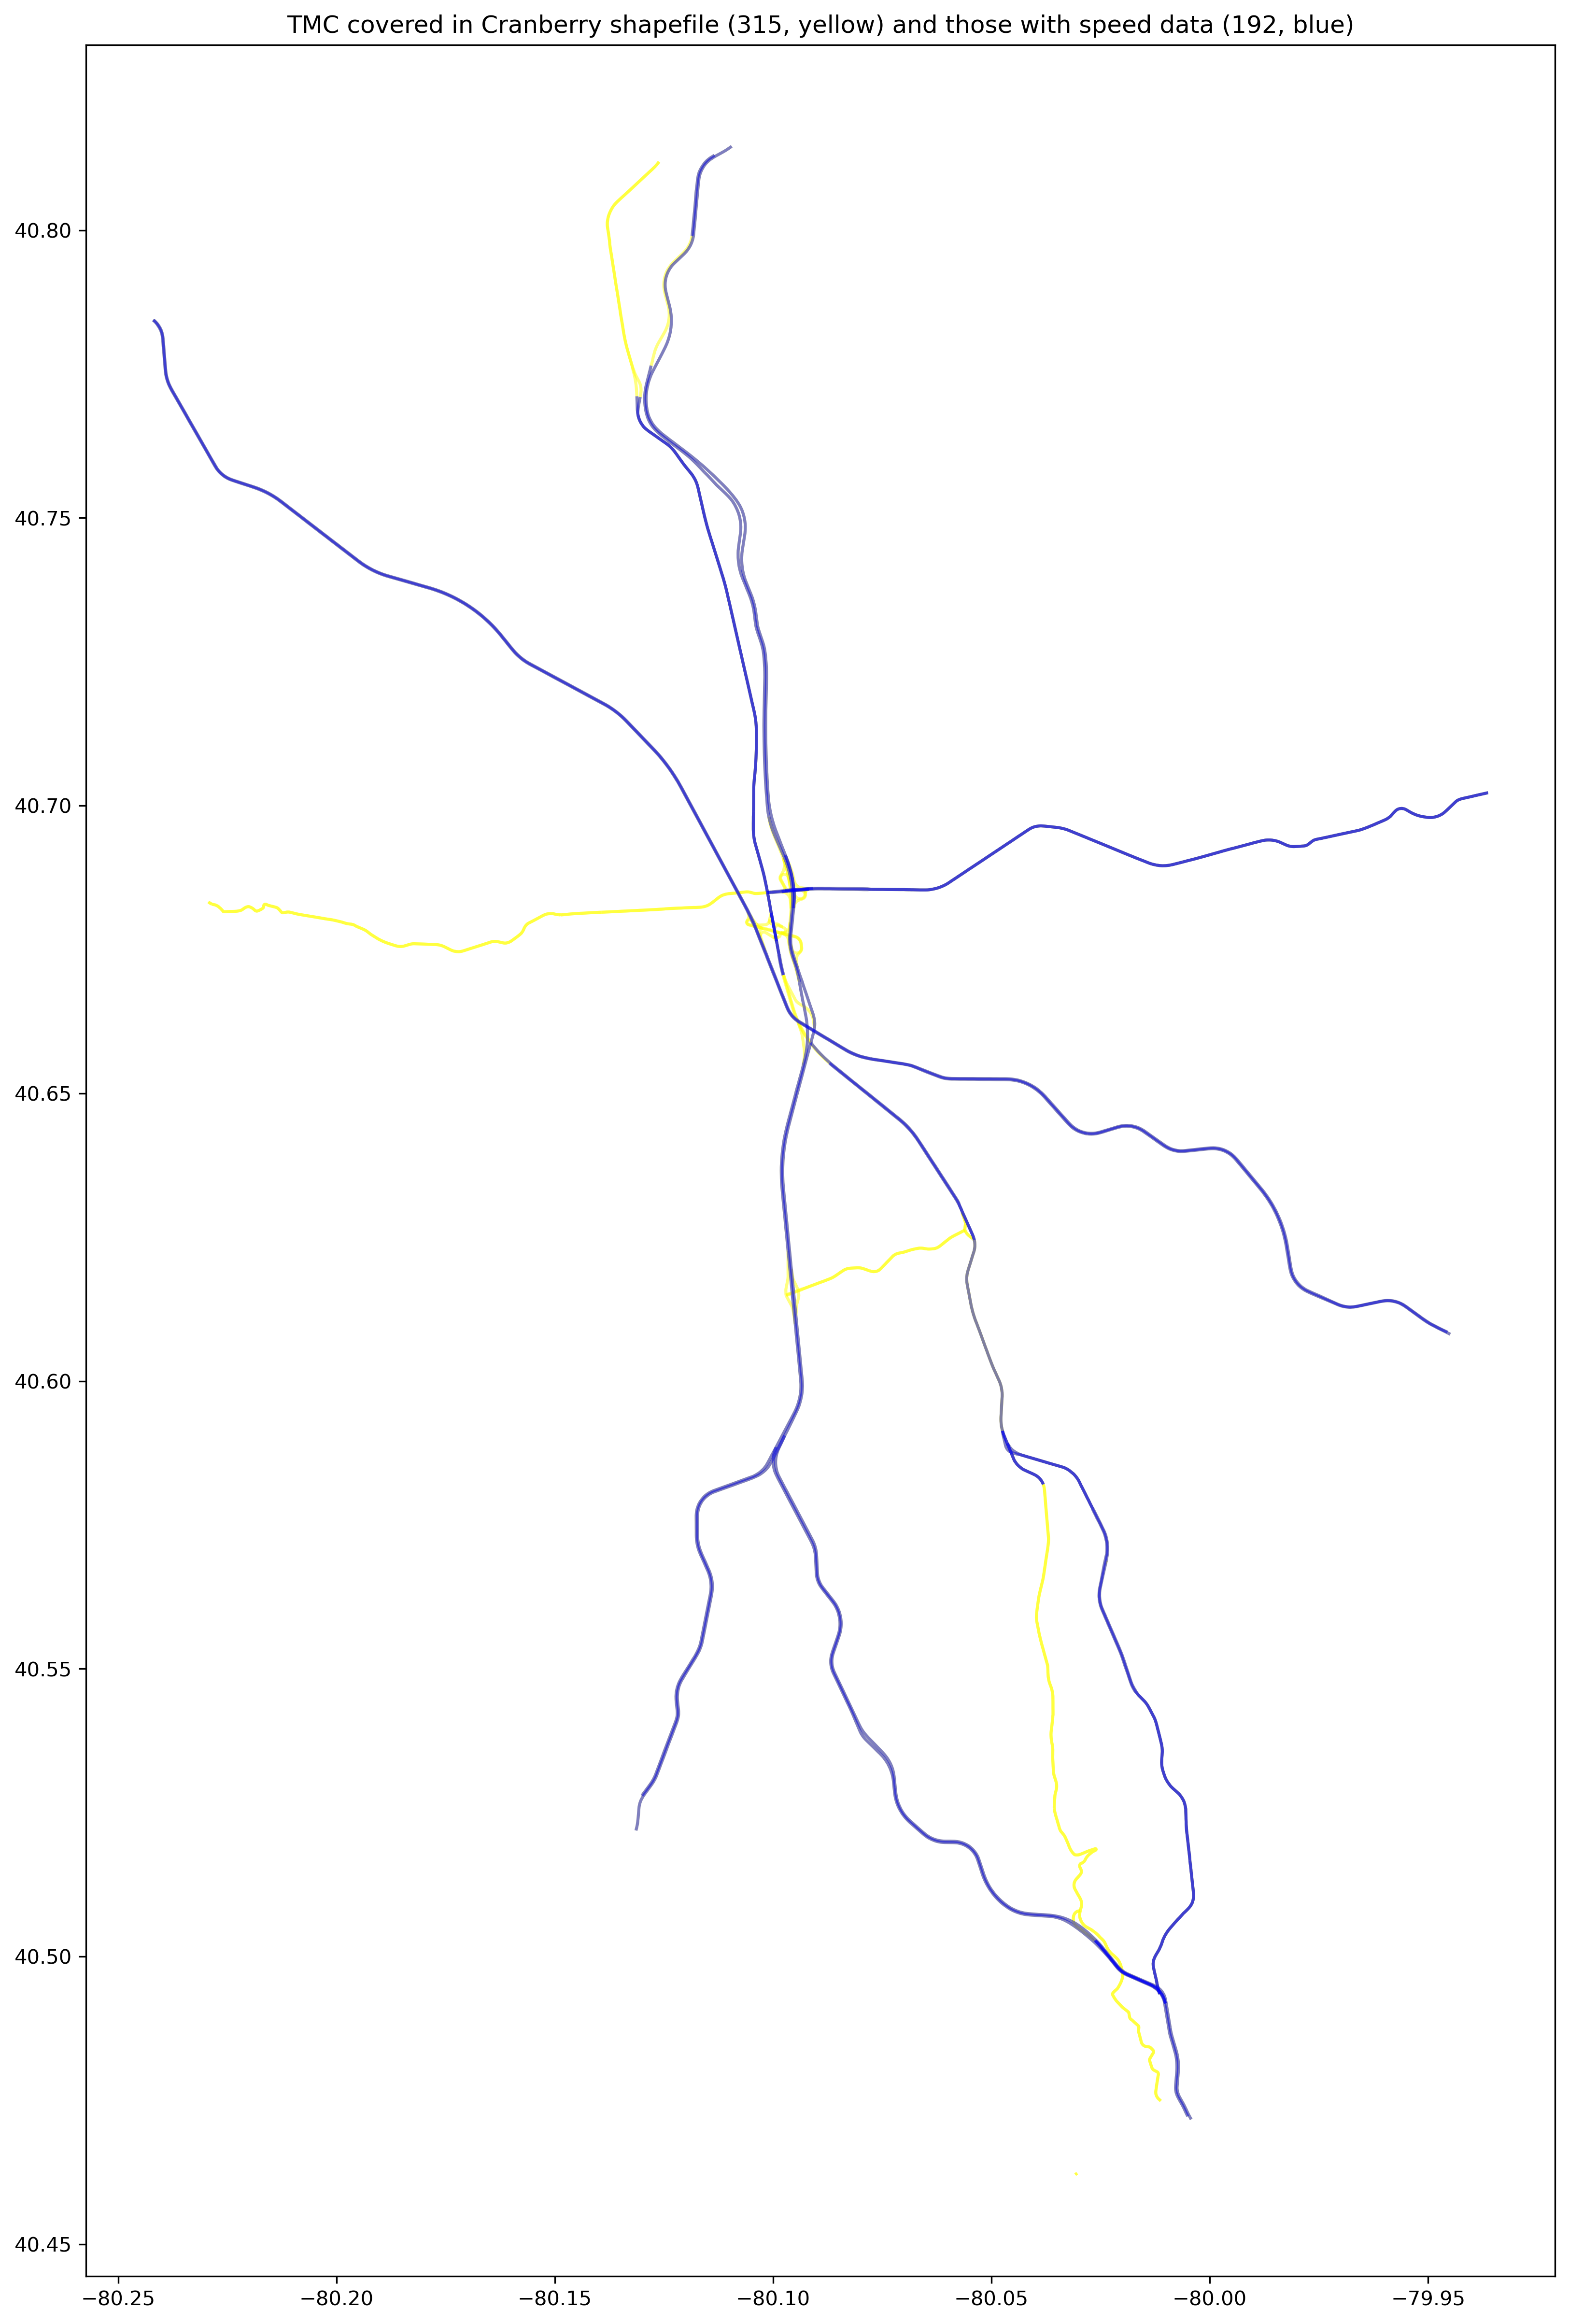

In [8]:
# Visualize 192 TMC segments covered by both shapefile and speeddata
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("TMC covered in Cranberry shapefile (315, yellow) and those with speed data (192, blue)")
gdf_shp_tmc.plot(ax=ax, color="yellow", alpha=0.5)
gdf_shp_tmc[gdf_shp_tmc.id.isin(set_tmc_segments)].plot(ax=ax, color="blue", alpha=0.5)

In [9]:
# Read TMC feature attributes
'''
'id_tmc', 'road', 'direction', 'intersection', 'state', 'county', 'zip',
       'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude',
       'miles_tmc', 'road_order', 'timezone_name', 'type', 'country',
       'tmclinear', 'frc', 'border_set', 'f_system', 'urban_code', 'faciltype',
       'structype', 'thrulanes', 'route_numb', 'route_sign', 'route_qual',
       'altrtename', 'aadt', 'aadt_singl', 'aadt_combi', 'nhs', 'nhs_pct',
       'strhnt_typ', 'strhnt_pct', 'truck', 'isprimary', 'active_start_date',
       'active_end_date'
'''
df_tmc_attr = pd.read_csv("../../data/cranberry_tmc_5min/manually_select_cranberry_2019_dont_average_2/TMC_Identification.csv")
df_tmc_attr = df_tmc_attr.rename(columns={"tmc": "id_tmc", "miles":"miles_tmc"})
df_tmc_attr = df_tmc_attr[df_tmc_attr.id_tmc.isin(set_tmc_segments)] # (195, 39)

In [10]:
df_tmc_attr

id_tmc    road   direction                  intersection state  \
100   104-09201   US-19  SOUTHBOUND        INGOMAR RD/YELLOW BELT    PA   
126   104P04742   US-19  NORTHBOUND         CRANBERRY INTERCHANGE    PA   
129   104P04740   US-19  NORTHBOUND  RED BELT/WARRENDALE BAYNE RD    PA   
157   104N06230  PA-228  SOUTHBOUND            PA-8/PITTSBURGH RD    PA   
172   104N06228  PA-228  SOUTHBOUND              MARS-VALENCIA RD    PA   
...         ...     ...         ...                           ...   ...   
1233  104-13683    I-76   EASTBOUND                PEARCE MILL RD    PA   
1238  104-04734   US-19  SOUTHBOUND       US-19-TRUCK/MCKNIGHT RD    PA   
1239  104-04735   US-19  SOUTHBOUND                     CHURCH RD    PA   
1240  104-04736   US-19  SOUTHBOUND                     CHAPEL DR    PA   
1241  104-04737   US-19  SOUTHBOUND                    WALLACE RD    PA   

         county    zip  start_latitude  start_longitude  end_latitude  ...  \
100   ALLEGHENY  15090        40.58765        -80.04555      40.58206  ...   
126      BUTLER  16066        40.67647        -80.09923      40.68140  ...   
129   ALLEGHENY  15086        40.65486        -80.08628      40.65523  ...   
157      BUTLER  16059        40.70225        -79.93626      40.70209  ...   
172      BUTLER  16046        40.69020        -80.00621      40.69001  ...   
...         ...    ...             ...              ...           ...  ...   
1233  ALLEGHENY  15090        40.65428        -80.06666      40.64307  ...   
1238  ALLEGHENY  15090        40.62452        -80.05392      40.59134  ...   
1239  ALLEGHENY  15090        40.62866        -80.05624      40.62488  ...   
1240  ALLEGHENY  15090        40.63332        -80.05958      40.62935  ...   
1241  ALLEGHENY  15090        40.64452        -80.06978      40.63332  ...   

      aadt_singl  aadt_combi  nhs nhs_pct strhnt_typ strhnt_pct  truck  \
100          394         130    1      57          0          0      0   
126         1424         581    1     100          0        100      0   
129         1147         363    1     100          0        100      0   
157          792         341    1     100          0        100      0   
172         1130         653    1     100          0        100      0   
...          ...         ...  ...     ...        ...        ...    ...   
1233           0           0    1     100          1        100      1   
1238         618          54    1     100          0          0      0   
1239         639          34    1     100          0        100      0   
1240         639          34    1     100          0        100      0   
1241         678         248    1      94          0          0      0   

      isprimary          active_start_date            active_end_date  
100           1  2019-01-01 00:00:00-05:00  2020-01-01 00:00:00-05:00  
126           1  2019-01-01 00:00:00-05:00  2020-01-01 00:00:00-05:00  
129           1  2019-01-01 00:00:00-05:00  2020-01-01 00:00:00-05:00  
157           1  2019-01-01 00:00:00-05:00  2020-01-01 00:00:00-05:00  
172           1  2019-01-01 00:00:00-05:00  2020-01-01 00:00:00-05:00  
...         ...                        ...                        ...  
1233          1  2019-01-01 00:00:00-05:00  2020-01-01 00:00:00-05:00  
1238          1  2019-01-01 00:00:00-05:00  2020-01-01 00:00:00-05:00  
1239          1  2019-01-01 00:00:00-05:00  2020-01-01 00:00:00-05:00  
1240          1  2019-01-01 00:00:00-05:00  2020-01-01 00:00:00-05:00  
1241          1  2019-01-01 00:00:00-05:00  2020-01-01 00:00:00-05:00  

[195 rows x 39 columns]

In [11]:
with open("./df_tmc_attr_for_upstream.pkl", "wb") as f:
    pickle.dump(df_tmc_attr, f)

In [12]:
dict_miles_tmc = dict(df_tmc_attr[["id_tmc", "miles_tmc"]].values)
with open("./dict_miles_tmc_for_upstream.pkl", "wb") as f:
    pickle.dump(dict_miles_tmc, f)

### 1.2 Calculate immediate prev and next neighbors for each TMC segment using their starting & ending positions

#### 1.2.1 Previous Segment

In [13]:
# Step 1. Join starting and ending positions
df_raw_prev_tmc = pd.merge(left=df_tmc_attr, right=df_tmc_attr, left_on=["start_latitude", "start_longitude"], right_on=["end_latitude", "end_longitude"], how="left") # shape (259, 78)

In [14]:
# Step 2. Compute angle and check for direction 
df_raw_prev_tmc["angle"] = df_raw_prev_tmc.apply(lambda x: angle(x.start_latitude_x, x.start_longitude_x, x.start_latitude_y, x.start_longitude_y, x.end_latitude_x, x.end_longitude_x, x.end_latitude_y, x.end_longitude_y), axis=1)
df_raw_prev_tmc["direction_matchness"] = df_raw_prev_tmc.apply(lambda x: check_direction(x.direction_x, x.direction_y), axis=1)
df_raw_prev_tmc = df_raw_prev_tmc[df_raw_prev_tmc.direction_matchness == 1].reset_index(drop=True) # each of the 190 tmc segments has the same direction as its prev segment, shape (183, 80) 

In [15]:
# summary of angle
df_raw_prev_tmc.angle.describe()

count    183.000000
mean       0.096314
std        0.090569
min        0.000148
25%        0.027498
50%        0.080167
75%        0.137962
max        0.575183
Name: angle, dtype: float64

In [16]:
# Step 3. output raw csv file for manual checking in QGIS
df_raw_prev_tmc.to_csv("./prev_tmc_raw.csv", index=False) 

104P04438 NORTHBOUND 104+04438 NORTHBOUND 0.1545816612097619


<AxesSubplot: >

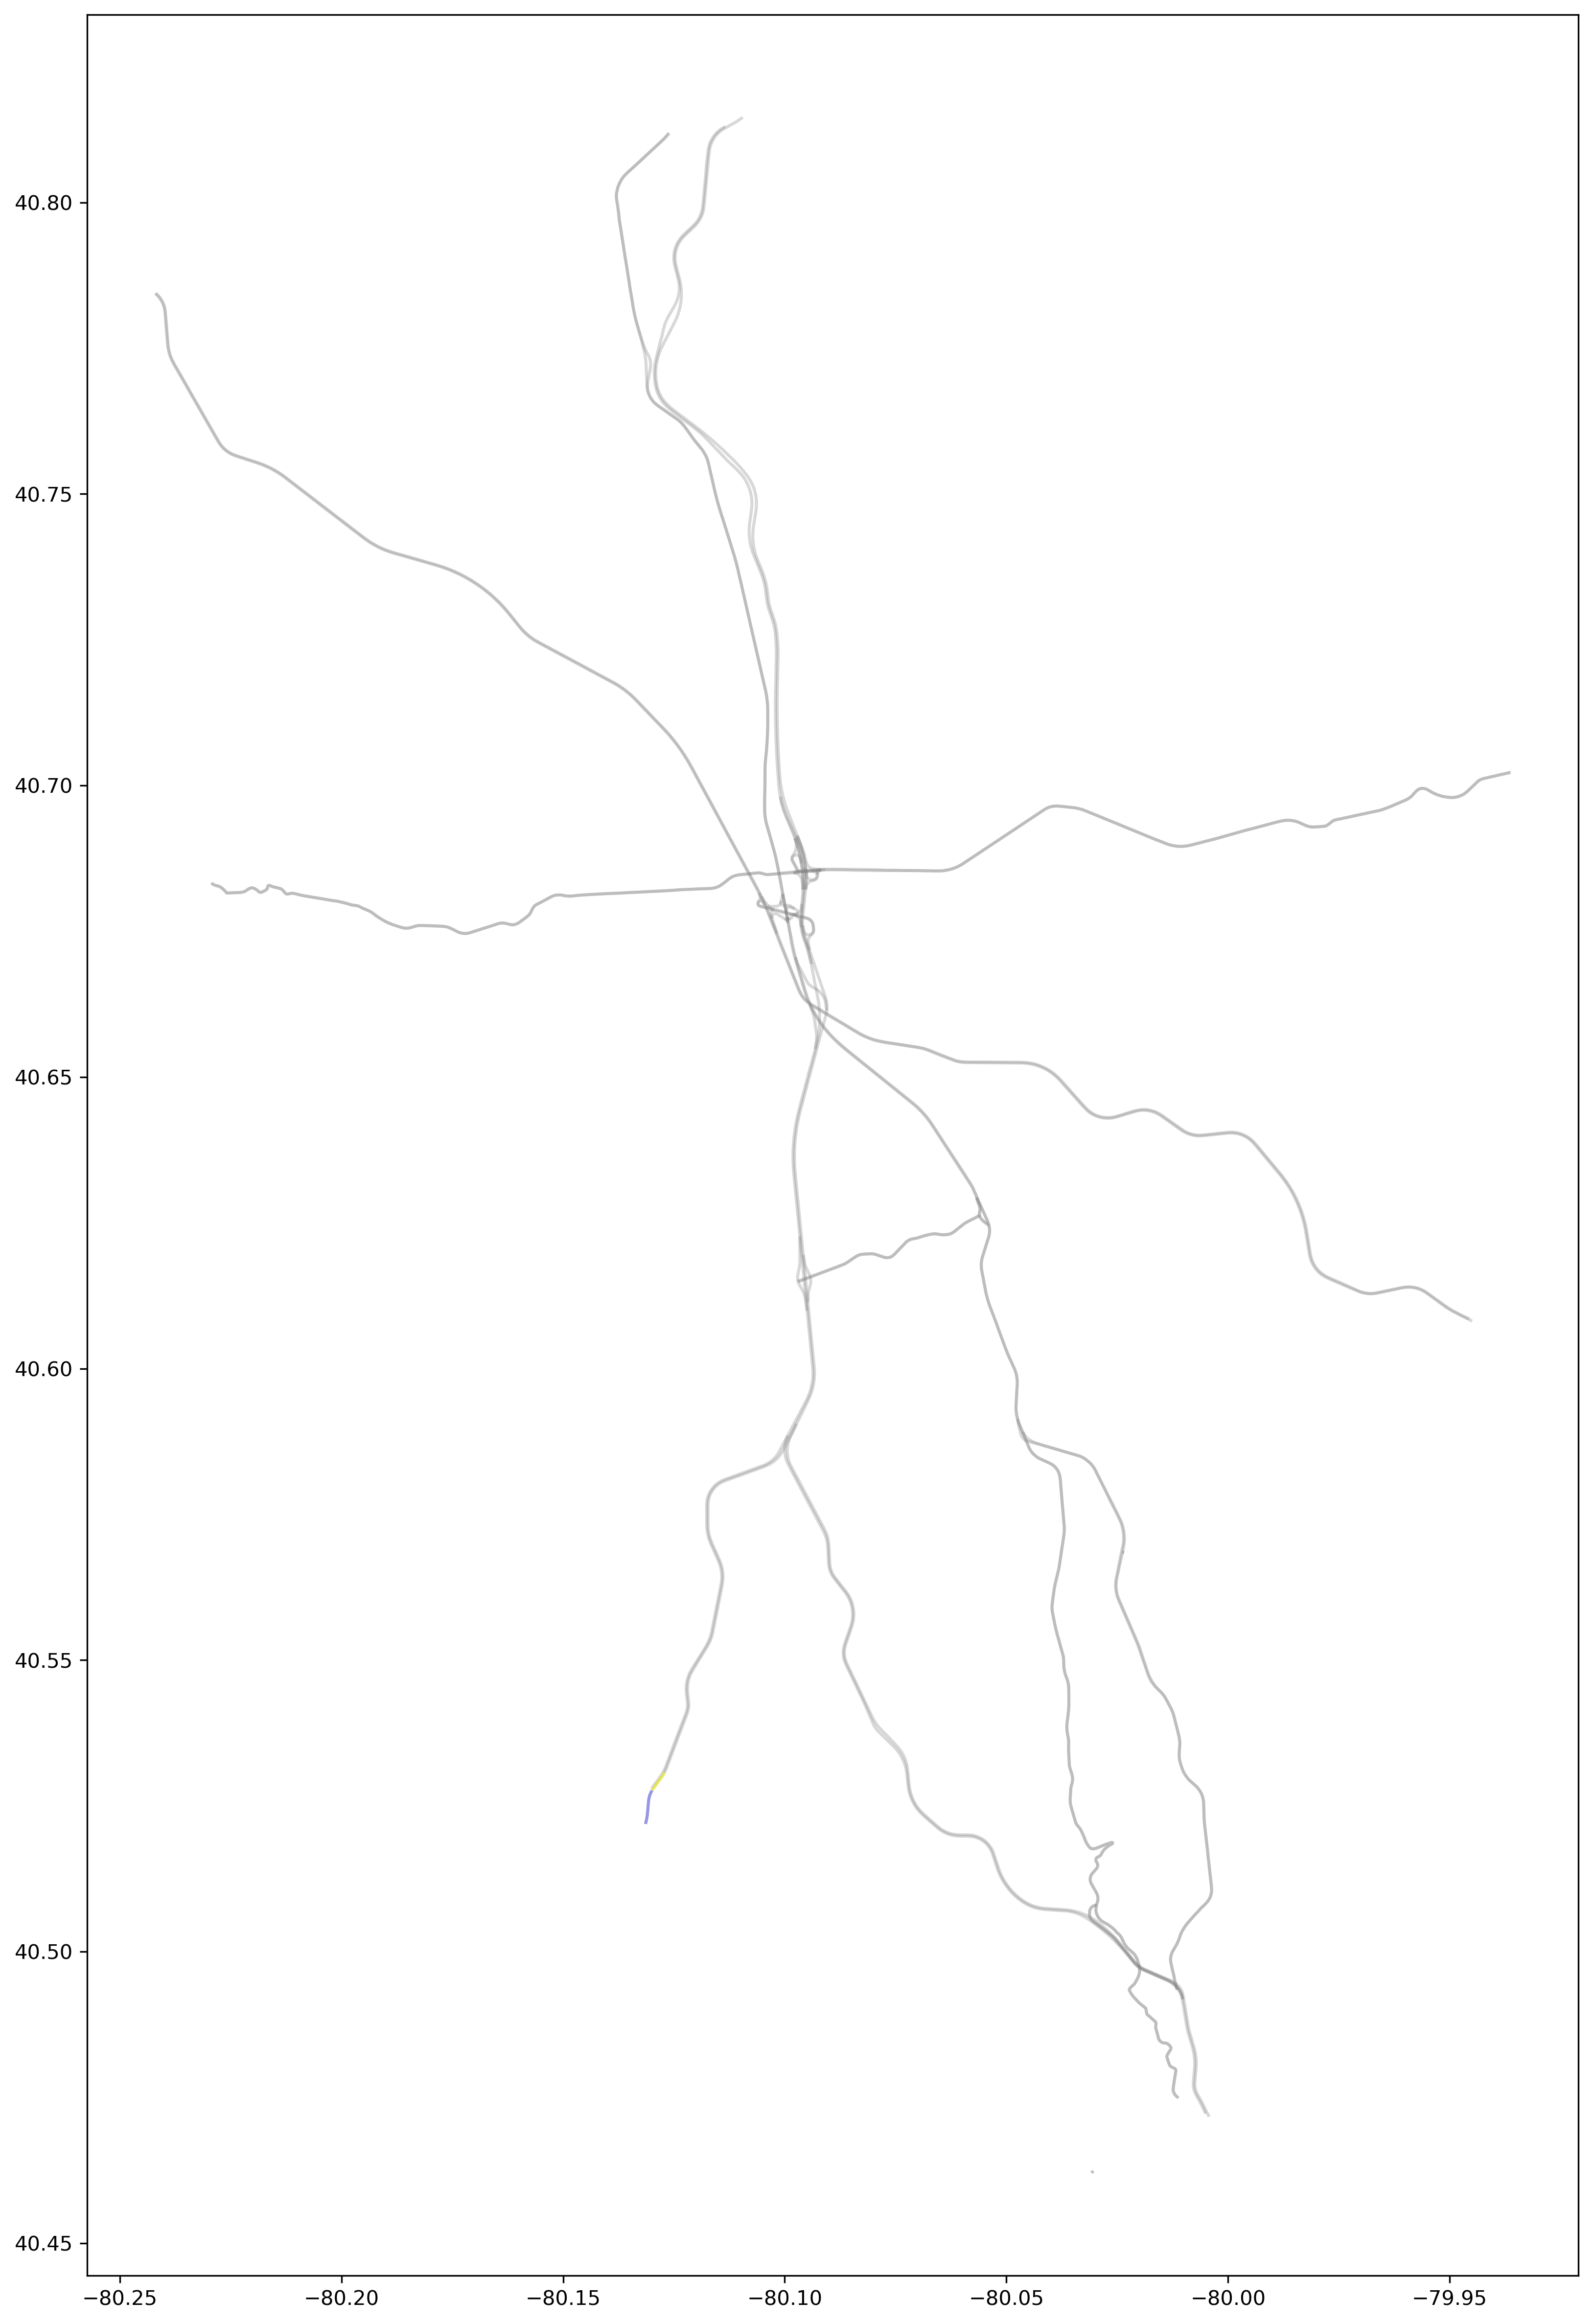

In [17]:
# Visualize and manually check initial calculation of previous neighbors

# df_raw_prev_tmc[df_raw_prev_tmc.angle > 0.1].sort_values(by="angle", ascending=False).index
# [163, 157,  16,  96,  45,  12,  22, 152, 176, 167,  95,  44,  75,
# 172,  24,  52,  73,  34,  37,  70, 166,  57, 114, 148,  78,  41,
#     23, 147, 175,  29,  84,  59,  79, 120, 165, 145,  89, 168, 162,
# 111, 132,  90,  61,   0,  11,  35,   6, 139, 102,  17, 119,  13,
#     72,  62, 128, 144, 137,  43, 109,  94, 151, 164, 154, 100,  47,
# 122,  76,  71,  33,  58,  20, 143, 160, 126, 123]
i = 120
check_curr_tmc = df_raw_prev_tmc.iloc[i].id_tmc_x
check_prev_tmc = df_raw_prev_tmc.iloc[i].id_tmc_y
print(check_curr_tmc, df_raw_prev_tmc.iloc[i].direction_x,check_prev_tmc, df_raw_prev_tmc.iloc[i].direction_y, df_raw_prev_tmc.iloc[i].angle)
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
gdf_shp_tmc.plot(ax=ax, color="grey", alpha=0.3)
gdf_shp_tmc[gdf_shp_tmc.id == check_curr_tmc].plot(ax=ax, color="yellow", alpha=0.5)
gdf_shp_tmc[gdf_shp_tmc.id == check_prev_tmc].plot(ax=ax, color="blue", alpha=0.3)

In [18]:
# Step 4. Load manually checked immediate previous segments
df_prev_tmc = pd.read_csv("./prev_tmc.csv")
df_prev_tmc = df_prev_tmc[["id_tmc_x", "id_tmc_y"]].groupby("id_tmc_x").agg(tuple).applymap(list).reset_index()
df_prev_tmc.columns = ["id_tmc", "prev_tmc"] # shape (180, 2)

In [19]:
df_prev_tmc

id_tmc                prev_tmc
0    104+04439             [104P04438]
1    104+04440             [104P04439]
2    104+04441  [104P04440, 104P04533]
3    104+04442             [104P04441]
4    104+04443             [104P04442]
..         ...                     ...
175  104P11466             [104+11466]
176  104P13682             [104+13682]
177  104P13683             [104+13683]
178  104P13684             [104+13684]
179  104P51754             [104+51754]

[180 rows x 2 columns]

In [20]:
df_prev_tmc[df_prev_tmc.prev_tmc.map(len) > 1]  # there are 3 TMC segments which have more than one immediate neighbors (index 1, 82, 140)

id_tmc                prev_tmc
2    104+04441  [104P04440, 104P04533]
83   104-04742  [104N06223, 104-06678]
143  104P04443  [104+04741, 104+04443]

<AxesSubplot: >

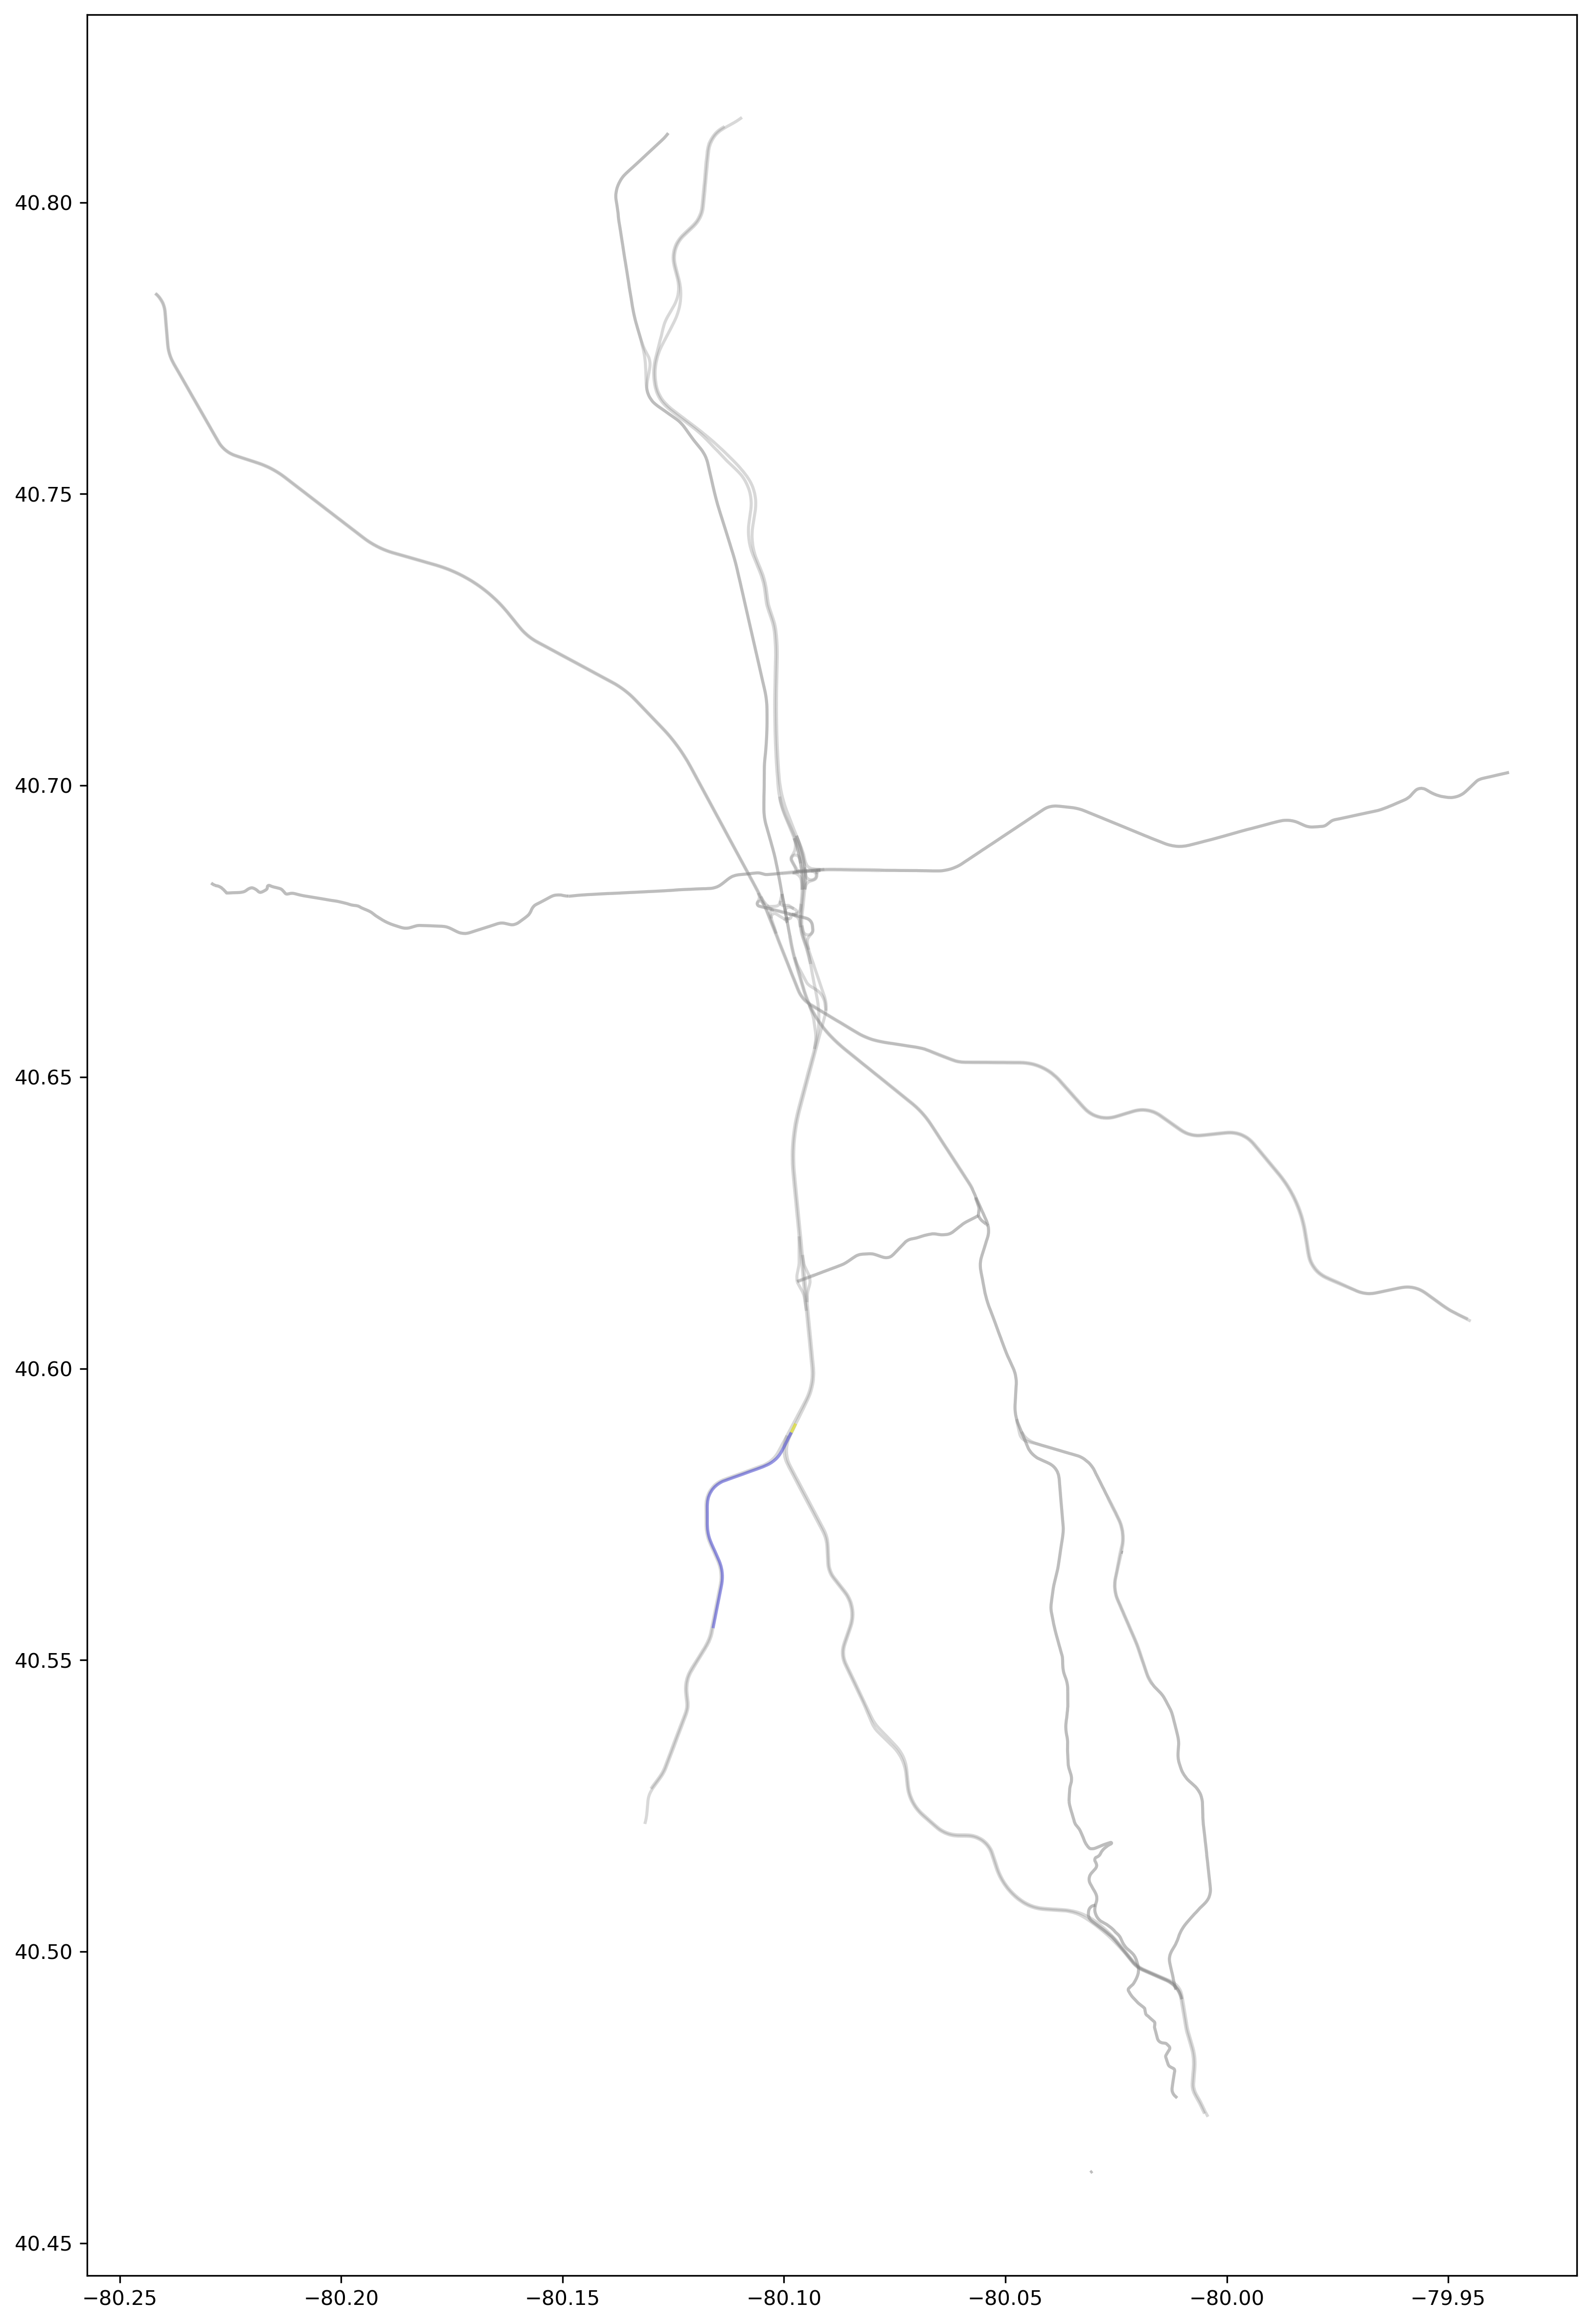

In [21]:
# Visualize and manually check intermediate calculation of previous neighbors
df_prev_tmc[df_prev_tmc.prev_tmc.map(len) > 1]  # index 2, 83, 143
i = 140
check_curr_tmc = df_prev_tmc.iloc[i].id_tmc
check_prev_tmc = df_prev_tmc.iloc[i].prev_tmc
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
gdf_shp_tmc.plot(ax=ax, color="grey", alpha=0.3)
gdf_shp_tmc[gdf_shp_tmc.id == check_curr_tmc].plot(ax=ax, color="yellow", alpha=0.5)
gdf_shp_tmc[gdf_shp_tmc.id.isin(check_prev_tmc)].plot(ax=ax, color="blue", alpha=0.3)

In [22]:
dict_prev_tmc = dict(df_prev_tmc.values) # contains 180 tmc segments, 3 of which have more than one immediate prev neighbor

{'104N04782', '104+04734', '104N04784', '104P04635', '104P04527', '104+04742', '104-06681', '104N06230', '104N04636', '104P04539', '104P04638', '104P04735', '104-04739', '104N13684', '104+04438'}


<AxesSubplot: title={'center': 'TMC Segments with (180, yellow) & without (15, blue) prev neighbors'}>

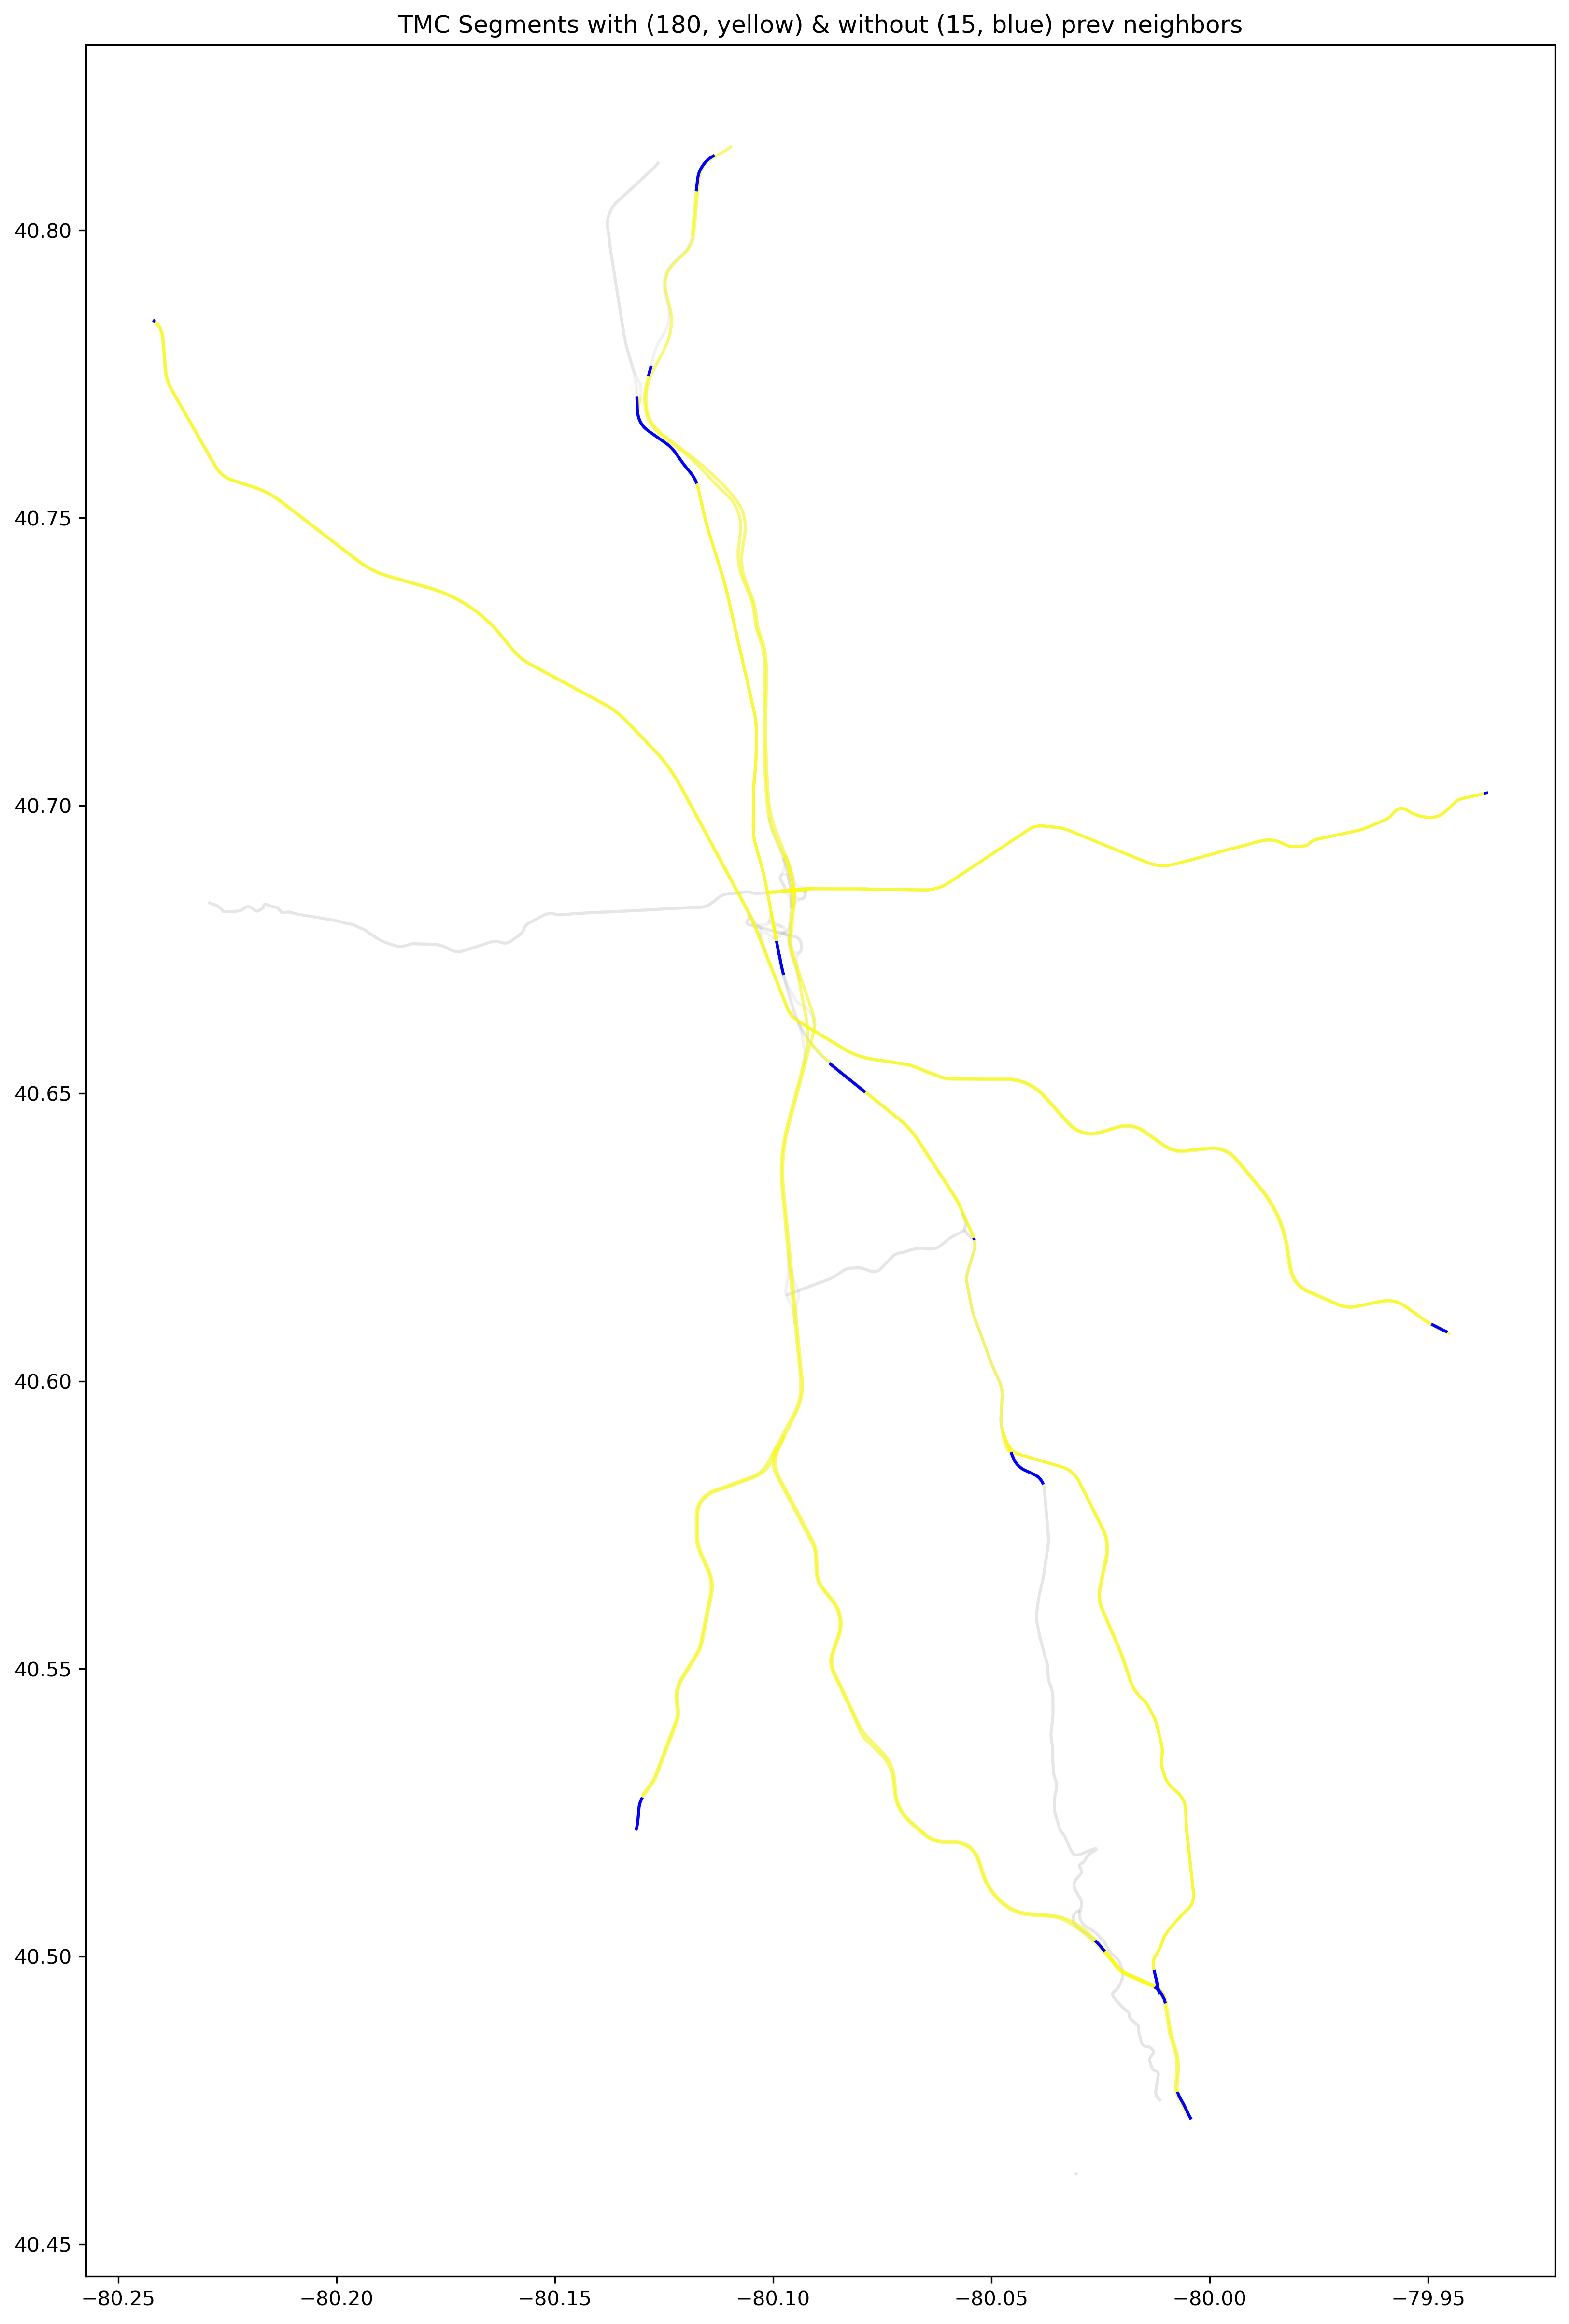

In [23]:
# Visualize and manually check segments without previous neighbors

# There are 15 segments without any immediate prev neighbor
# I have manually checked their neighbors on QGIS (with cranberry_tmc and PA_tmc), they either go missing in cranberry_tmc shapefile or lack speed data
print(set_tmc_segments.difference(dict_prev_tmc)) 

fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("TMC Segments with (180, yellow) & without (15, blue) prev neighbors")
gdf_shp_tmc.plot(ax=ax, color="grey", alpha=0.1)
gdf_shp_tmc[gdf_shp_tmc.id.isin(set_tmc_segments)].plot(ax=ax, color="yellow", alpha=0.5)
gdf_shp_tmc[(gdf_shp_tmc.id.isin(set_tmc_segments)) & (~gdf_shp_tmc.id.isin(dict_prev_tmc))].plot(ax=ax, color="blue")

In [24]:
with open("../../data/dict_prev_tmc.pkl", "wb") as f:
    pickle.dump(dict_prev_tmc, f)

#### 1.2.2 Immediate Next Segment (TODO)

### 1.3 Calculate upstream and downstream neighbors for each TMC segment using their immediate prev and next

In [25]:
dict_upstream_tmc = {}
for source in tqdm(list(set_tmc_segments)):
    dict_upstream_tmc[source] = compute_upstream(source=source, dict_prev=dict_prev_tmc, dict_upstream=dict_upstream_tmc)

100%|██████████| 195/195 [00:00<00:00, 126217.48it/s]


current tmc:  104+11466 434    NORTHBOUND
Name: direction, dtype: object
upstream:  [['104P04443', '104+04741', '104P04740', '104+04740', '104P04739', '104+04739', '104+04738', '104+04737', '104P04736', '104+04736', '104P04735'], ['104P04443', '104+04443', '104P04442', '104+04442', '104P04441', '104+04441', '104P04440', '104+04440', '104P04439', '104+04439', '104P04438', '104+04438'], ['104P04443', '104+04443', '104P04442', '104+04442', '104P04441', '104+04441', '104P04533', '104+04533', '104P04532', '104+04532', '104P04531', '104+04531', '104P04530', '104+04530', '104P04529', '104+04529', '104P04528', '104+04528', '104P04527']]
MORE THAN ONE UPSTREAM PATH!!! There are 3 upstream paths


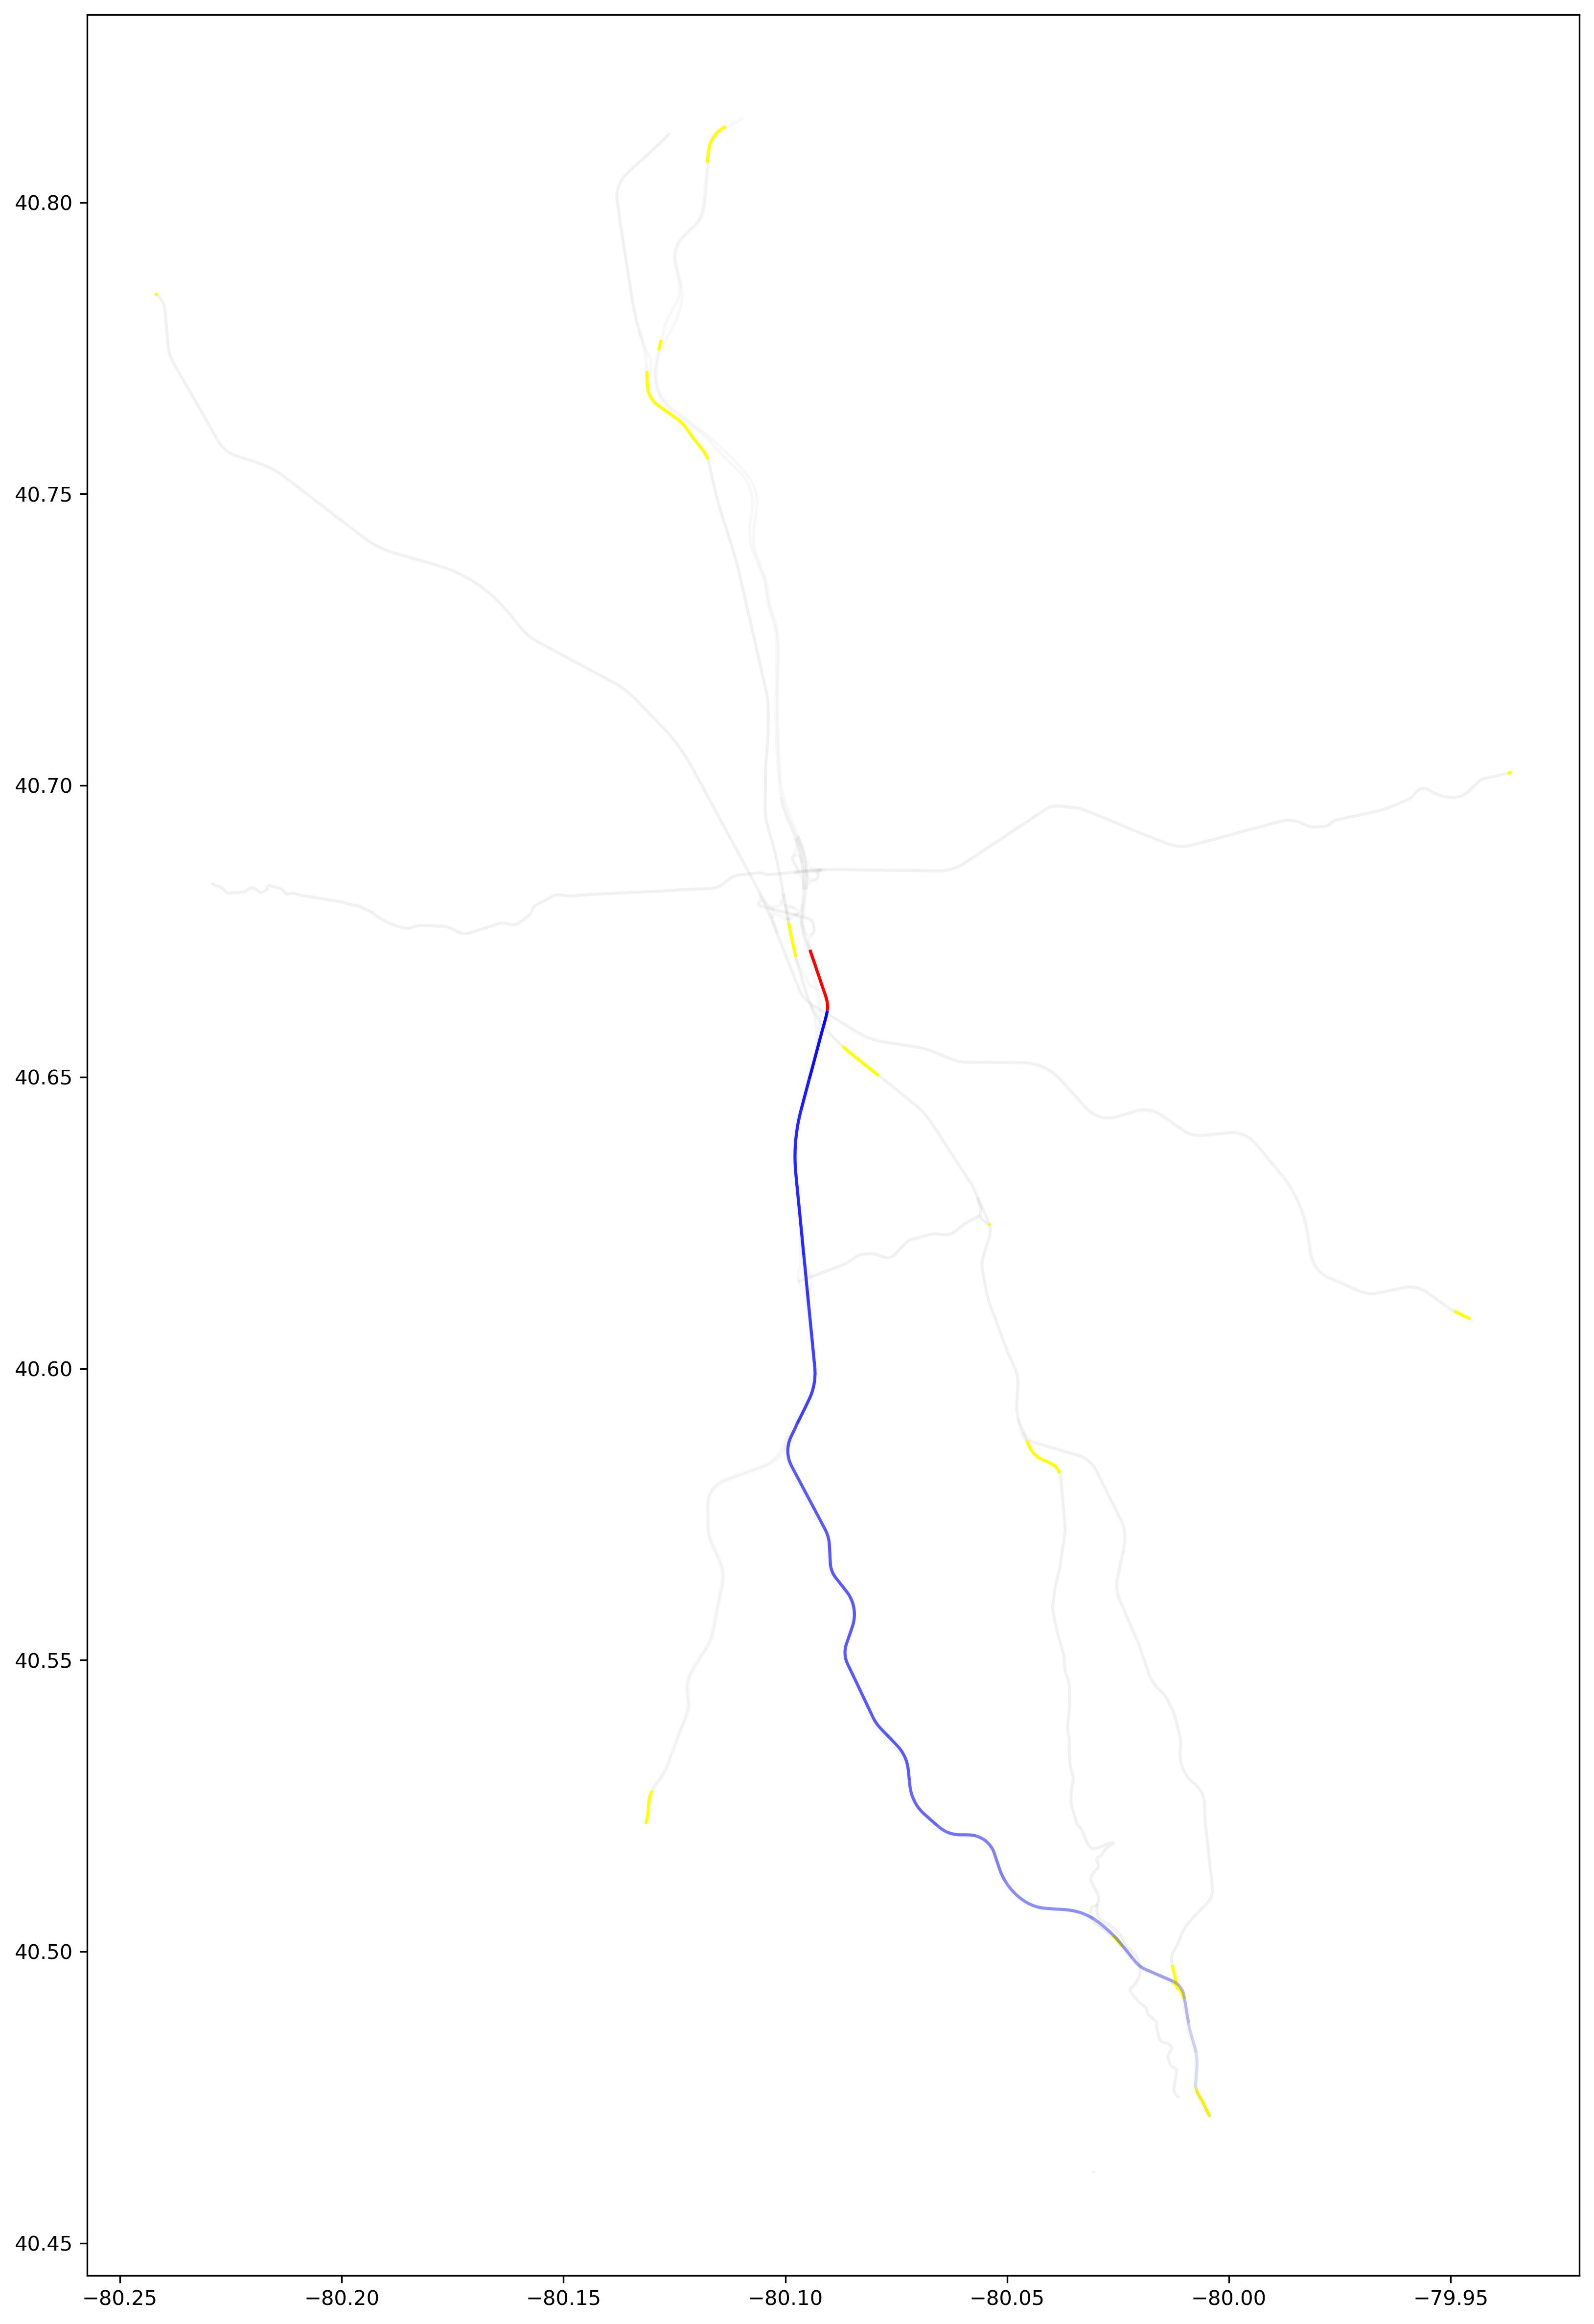

In [30]:
# Visualize and manually check upstream segments starting from each of 195 segments
i = 2
check_curr_tmc = list(set_tmc_segments)[i]
print("current tmc: ", check_curr_tmc, df_tmc_attr[df_tmc_attr.id_tmc == check_curr_tmc].direction)
check_upstream = dict_upstream_tmc[check_curr_tmc]
print("upstream: ", check_upstream)
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
gdf_shp_tmc.plot(ax=ax, color="grey", alpha=0.05) # entire TMC segments in cranberry 
gdf_shp_tmc[(gdf_shp_tmc.id.isin(set_tmc_segments)) & (~gdf_shp_tmc.id.isin(dict_prev_tmc))].plot(ax=ax, color="yellow") # TMC segments without prev neighbors
gdf_shp_tmc[gdf_shp_tmc.id == check_curr_tmc].plot(ax=ax, color="red") # source
if len(check_upstream) > 1:
    print(f"MORE THAN ONE UPSTREAM PATH!!! There are {len(check_upstream)} upstream paths")
j = 2
for k, u in enumerate(check_upstream[j]):
    gdf_shp_tmc[gdf_shp_tmc.id == u].plot(ax=ax, color="blue", alpha= (len(check_upstream[j])-k)/len(check_upstream[j]))  # upstream segments

In [31]:
with open("../../data/dict_upstream_tmc.pkl", "wb") as f:
    pickle.dump(dict_upstream_tmc, f)

## 2. Get Upsteam and Downstream XD Segments

In [27]:
# xd_attr = pd.read_csv("./data/shapefiles/xd_attr.csv")
# xd_attr.XDSegID = xd_attr.XDSegID.apply(int).apply(str)
# xd_attr.PreviousXD = xd_attr.PreviousXD.apply(lambda x: str(int(x)) if not np.isnan(x) else x)
# xd_attr.NextXDSegI = xd_attr.NextXDSegI.apply(lambda x: str(int(x)) if not np.isnan(x) else x)
# xd_attr = xd_attr.rename(columns={"XDSegID":"id_xd", "PreviousXD":"id_xd_prev", "NextXDSegI":"id_xd_next", "Miles":"miles_xd"})
# xd_attr.to_csv("./data/shapefiles/xd_attr.csv", index=False)

# core_xd_attr = xd_attr.loc[:,["id_xd", "id_xd_prev", "id_xd_next", "miles_xd"]]
# core_xd_attr = core_xd_attr.set_index(keys="id_xd")
# core_xd_attr.to_csv("./data/shapefiles/core_xd_attr.csv")

In [14]:
list_spd_xd_segments = list(pd.read_csv("../../data/cranberry_xd_1min/manually_select_cranberry_class123_20181101_20190727_dont_average/XD_Identification.csv").xd)  # 1628 xd segments from speed data, (1628, 14)

In [15]:
set_spd_xd_segments = set([str(l) for l in list_spd_xd_segments]).union(set([str(t) for t in list(tmc_xd_join.id_xd.unique())])) # 1726 xd segments

In [17]:
gdf_shp_xd = gpd.read_file("../../data/shape/xd_shape_cranberry/v1/xd_cranberry_for_sjoin.geojson") # 556 xd segments from shapefile
gdf_shp_xd = gdf_shp_xd.rename(columns={"XDSegID":"id_xd_str", "PreviousXD":"id_xd_prev", "NextXDSegI":"id_xd_next", "Miles":"miles_xd"})

In [18]:
gdf_shp_xd

OID   id_xd_str  id_xd_prev  id_xd_next FRC RoadNumber         RoadName  \
0    None   132112962        None        None   4       None    Duncan Avenue   
1    None   132158129  1310596942   134453381   2       None    Duncan Avenue   
2    None   132403172        None        None   4       None   Mennonite Lane   
3    None   132873381        None   132544667   3       None  Thorn Hill Road   
4    None   132883695        None        None   2       None    Duncan Avenue   
..    ...         ...         ...         ...  ..        ...              ...   
551  None  1310613582   389110060        None   1         19            US 19   
552  None  1310613581        None   388075734   1         19            US 19   
553  None  1310613588   388075729  1310583855   1         19            US 19   
554  None  1310613589   389110259   389110060   1         19            US 19   
555  None  1310614041  1310441752   389254810   0         19      US 19 Truck   

    LinearID        Country         State  ... SpecialRoa  \
0       None  United States  Pennsylvania  ...       None   
1       None  United States  Pennsylvania  ...       None   
2       None  United States  Pennsylvania  ...       None   
3       None  United States  Pennsylvania  ...       None   
4       None  United States  Pennsylvania  ...       None   
..       ...            ...           ...  ...        ...   
551     None  United States  Pennsylvania  ...       None   
552     None  United States  Pennsylvania  ...       None   
553     None  United States  Pennsylvania  ...       None   
554     None  United States  Pennsylvania  ...       None   
555     None  United States  Pennsylvania  ...       None   

                 RoadList  StartLat  StartLong    EndLat    EndLong Bearing  \
0           Duncan Avenue  40.56849  -80.02401  40.56869  -80.02644       W   
1           Duncan Avenue  40.56717  -80.01648  40.56847  -80.02383       W   
2    Mennonite Lane,US 19  40.80928  -80.12924  40.80937  -80.12941       W   
3         Thorn Hill Road  40.66731  -80.09635  40.66731  -80.09651       W   
4           Duncan Avenue  40.56849  -80.02401  40.56847  -80.02383       E   
..                    ...       ...        ...       ...        ...     ...   
551                 US 19  40.49025  -80.01854  40.49276  -80.02177       N   
552                 US 19  40.49276  -80.02177  40.49025  -80.01854       S   
553                 US 19  40.48381  -80.01307  40.47845    -80.012       S   
554                 US 19  40.48381  -80.01307  40.48954  -80.01837       N   
555           US 19 Truck  40.55613  -80.02215  40.56891  -80.02371       N   

     XDGroup ShapeSRID                                           geometry  
0     441098      4326  MULTILINESTRING ((-80.02401 40.56849, -80.0242...  
1     441098      4326  MULTILINESTRING ((-80.01648 40.56717, -80.0166...  
2     449088      4326  MULTILINESTRING ((-80.12924 40.80928, -80.1292...  
3     463412      4326  MULTILINESTRING ((-80.09635 40.66731, -80.0965...  
4     463726      4326  MULTILINESTRING ((-80.02401 40.56849, -80.0238...  
..       ...       ...                                                ...  
551   474329      4326  MULTILINESTRING ((-80.01854 40.49025, -80.0185...  
552   531444      4326  MULTILINESTRING ((-80.02177 40.49276, -80.0217...  
553   531444      4326  MULTILINESTRING ((-80.01307 40.48381, -80.0130...  
554   474329      4326  MULTILINESTRING ((-80.01307 40.48381, -80.0132...  
555  2012062      4326  MULTILINESTRING ((-80.02215 40.55613, -80.0227...  

[556 rows x 25 columns]

In [19]:
set_shp_xd_segments = set(gdf_shp_xd.id_xd_str)

In [20]:
set_xd_segments = set_shp_xd_segments.intersection(set_spd_xd_segments) # 448 xd segments

In [21]:
with open("./set_xd_segments_str_for_upstream.pkl", "wb") as f:
    pickle.dump(set_xd_segments, f)

<AxesSubplot: title={'center': 'XD Segments in cranberry shapefile (556, yellow) with speed data (448, blue)'}>

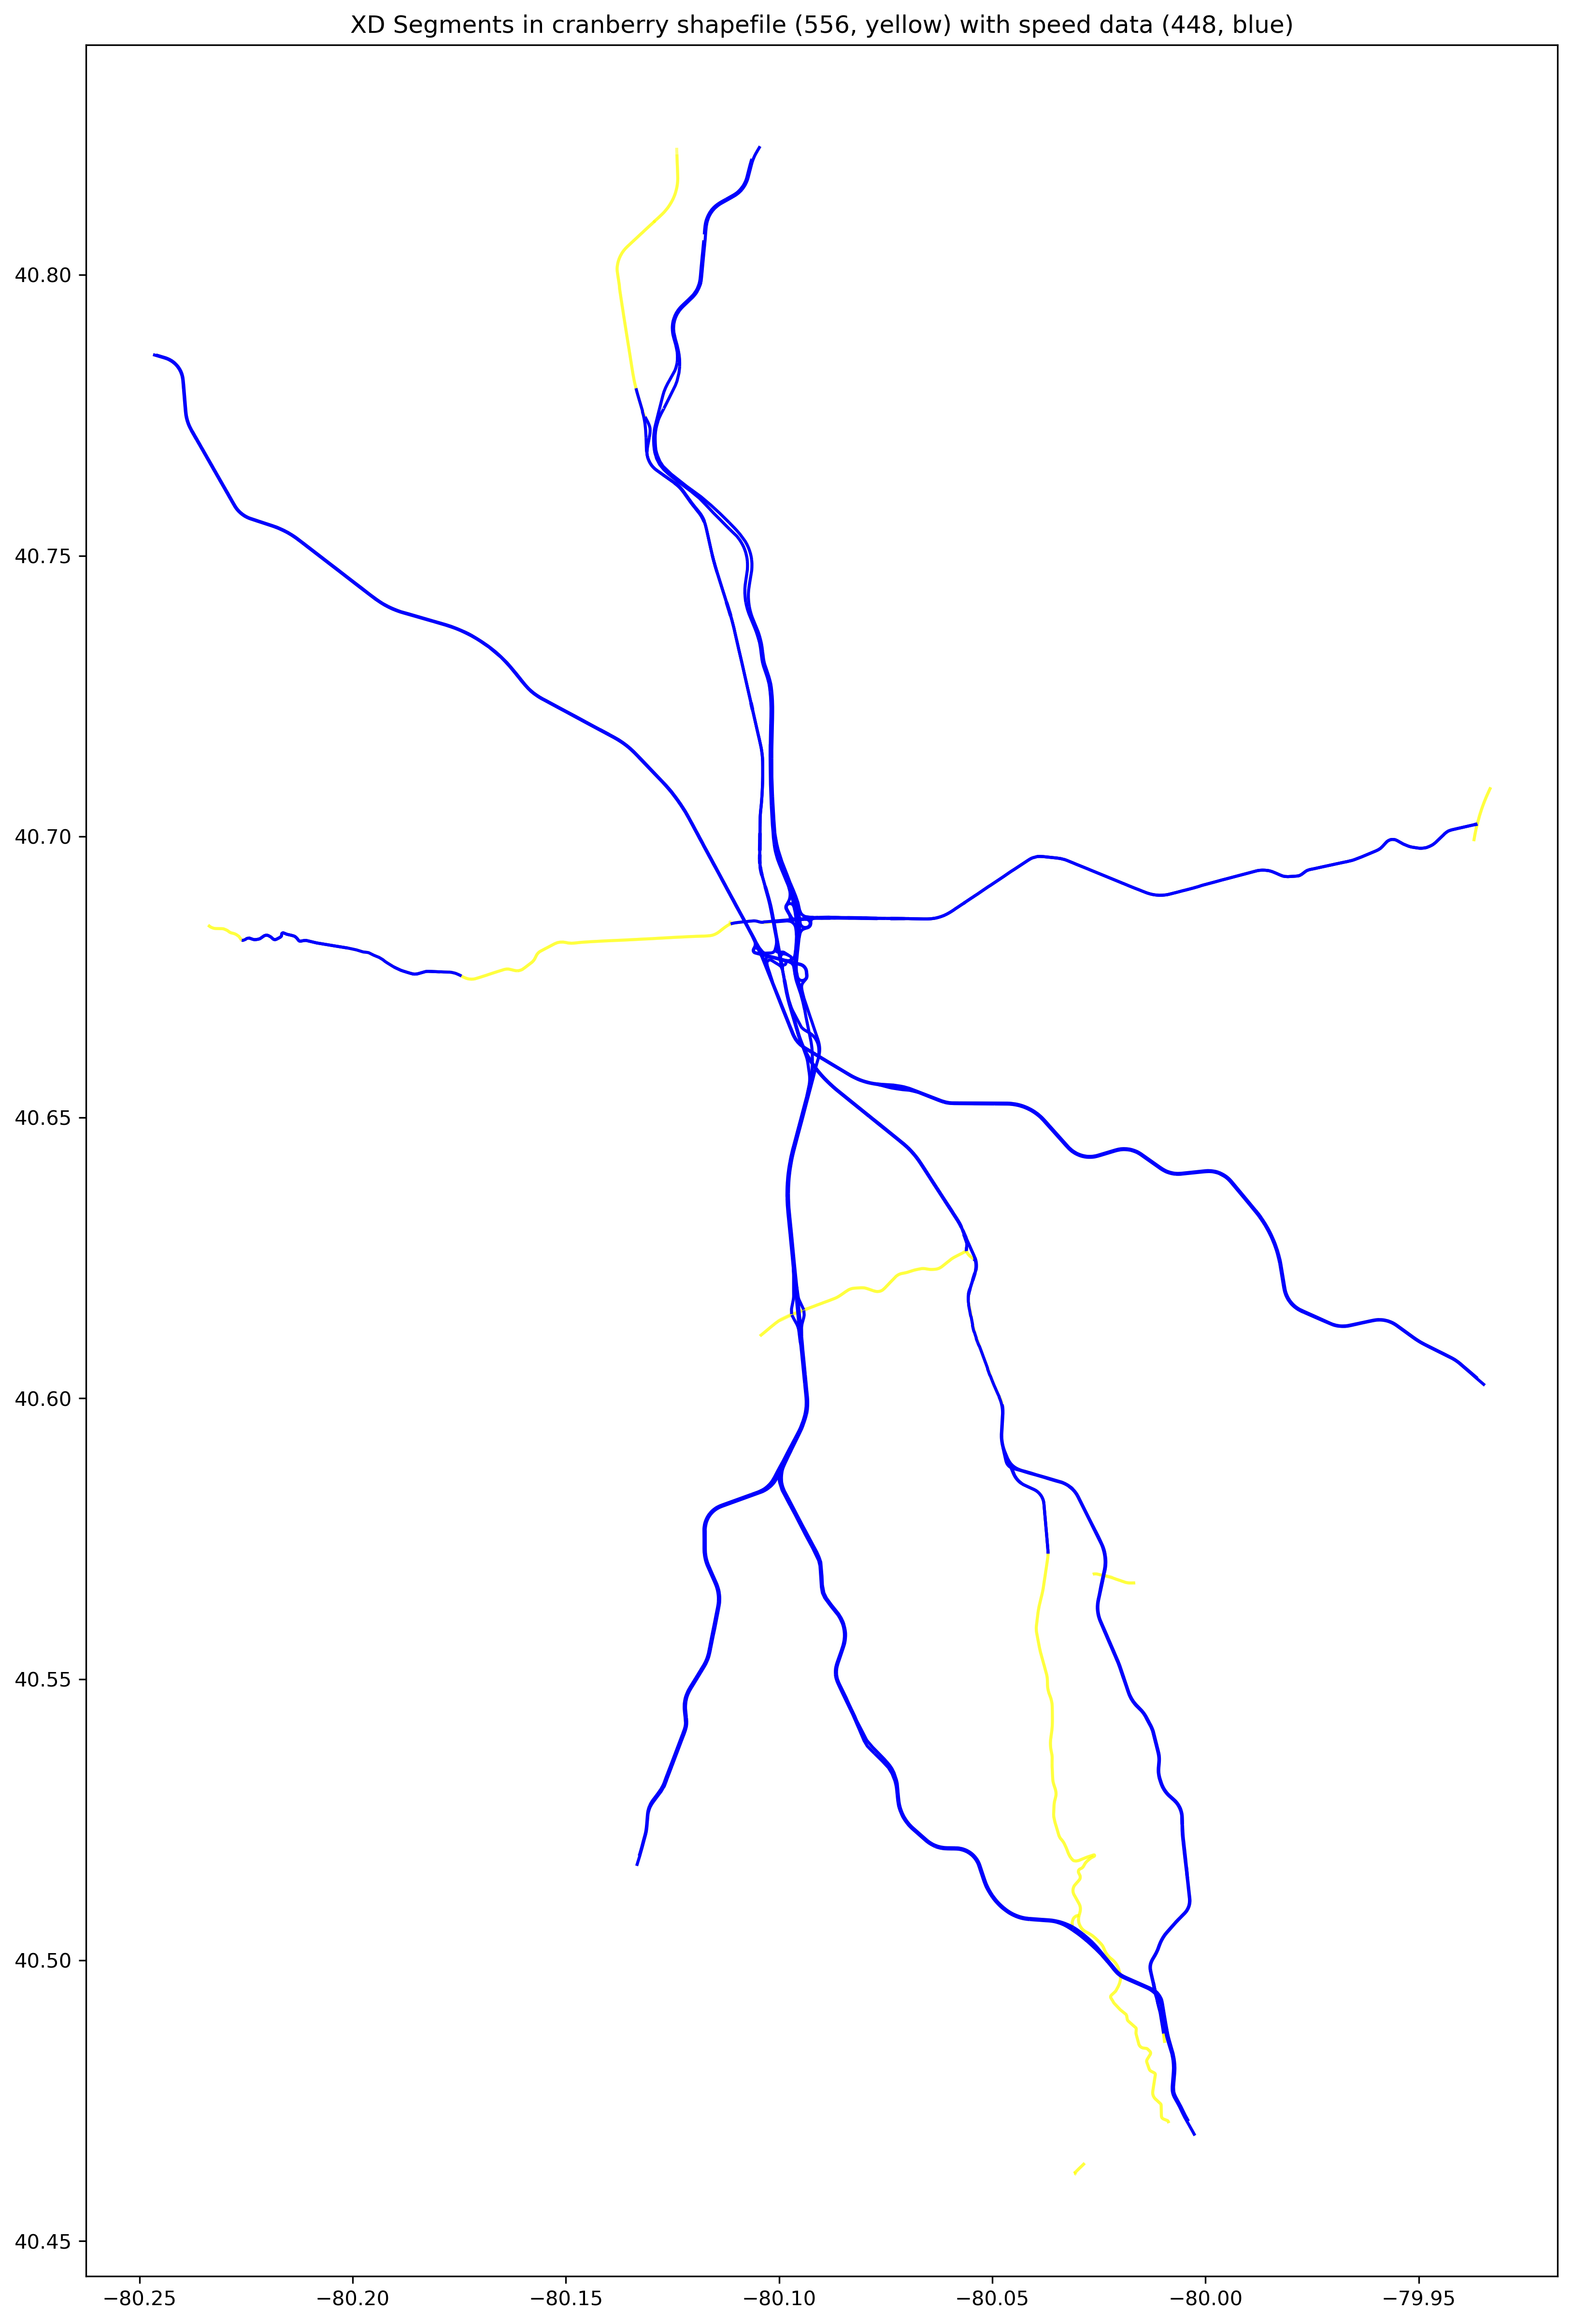

In [22]:
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("XD Segments in cranberry shapefile (556, yellow) with speed data (448, blue)")
gdf_shp_xd.plot(ax=ax, color="yellow", alpha=0.5)
gdf_shp_xd[gdf_shp_xd.id_xd_str.isin(set_xd_segments)].plot(ax=ax, color="blue")

In [23]:
# 448 xd
# 45 lack prev neighbor
# 48 lack next neighbor
# 22 lack both prev and next neighbors
# 71 lack prev or next neighbors

# 'OID', 'id_xd_str', 'id_xd_prev', 'id_xd_next', 'FRC', 'RoadNumber',
#        'RoadName', 'LinearID', 'Country', 'State', 'County', 'District',
#        'miles_xd', 'Lanes', 'SlipRoad', 'SpecialRoa', 'RoadList', 'StartLat',
#        'StartLong', 'EndLat', 'EndLong', 'Bearing', 'XDGroup', 'ShapeSRID',
#        'geometry'
df_xd_attr = pd.DataFrame(gdf_shp_xd[gdf_shp_xd.id_xd_str.isin(set_xd_segments)]).reset_index(drop=True) 
df_xd_attr.miles_xd = df_xd_attr.miles_xd.astype(float)

In [24]:
df_xd_attr

OID   id_xd_str  id_xd_prev  id_xd_next FRC RoadNumber  \
0    None   134149761   429090780   135262369   0        228   
1    None   134198813        None        None   4       None   
2    None   134357035  1310384877  1310384902   0         76   
3    None   134370382   388033425        None   2       None   
4    None   134452998  1310377467   429110245   0        228   
..    ...         ...         ...         ...  ..        ...   
443  None  1310597520        None   429090786   0       None   
444  None  1310604066  1310406350  1310545748   0         79   
445  None  1310604584  1310362397   429090781   0       None   
446  None  1310609751        None        None   0         19   
447  None  1310614041  1310441752   389254810   0         19   

                   RoadName LinearID        Country         State  ...  \
0                    PA 228     None  United States  Pennsylvania  ...   
1    Wallace Road Extension     None  United States  Pennsylvania  ...   
2                 I 76;PATP     None  United States  Pennsylvania  ...   
3              Wallace Road     None  United States  Pennsylvania  ...   
4                    PA 228     None  United States  Pennsylvania  ...   
..                      ...      ...            ...           ...  ...   
443                    None     None  United States  Pennsylvania  ...   
444                    I 79     None  United States  Pennsylvania  ...   
445                    None     None  United States  Pennsylvania  ...   
446             US 19 Truck     None  United States  Pennsylvania  ...   
447             US 19 Truck     None  United States  Pennsylvania  ...   

    SpecialRoa                RoadList  StartLat  StartLong    EndLat  \
0         None                  PA 228   40.6852  -80.09726  40.68495   
1         None  Wallace Road Extension  40.63794  -80.06355  40.63799   
2         None               I 76;PATP   40.6524  -80.04947  40.64956   
3         None            Wallace Road  40.63343  -80.05949  40.63337   
4         None                  PA 228  40.68479  -80.10137    40.685   
..         ...                     ...       ...        ...       ...   
443       None                    None   40.6819  -80.09532   40.6848   
444       None                    I 79  40.62322  -80.09667  40.60958   
445       None                    None  40.67701  -80.10277  40.67858   
446       None             US 19 Truck  40.59133  -80.04752   40.5868   
447       None             US 19 Truck  40.55613  -80.02215  40.56891   

       EndLong Bearing  XDGroup ShapeSRID  \
0    -80.10123       W   503991      4326   
1    -80.06341       E   505632      4326   
2    -80.03812       E   510710      4326   
3    -80.05964       W   448690      4326   
4    -80.09809       E   514061      4326   
..         ...     ...      ...       ...   
443  -80.09259       N  3612954      4326   
444  -80.09492       S   504096      4326   
445  -80.10212       N  2506677      4326   
446  -80.04179       S  3620085      4326   
447  -80.02371       N  2012062      4326   

                                              geometry  
0    MULTILINESTRING ((-80.09726 40.68520, -80.0974...  
1    MULTILINESTRING ((-80.06355 40.63794, -80.0634...  
2    MULTILINESTRING ((-80.04947 40.65240, -80.0464...  
3    MULTILINESTRING ((-80.05949 40.63343, -80.0596...  
4    MULTILINESTRING ((-80.10137 40.68479, -80.1011...  
..                                                 ...  
443  MULTILINESTRING ((-80.09532 40.68190, -80.0951...  
444  MULTILINESTRING ((-80.09667 40.62322, -80.0963...  
445  MULTILINESTRING ((-80.10277 40.67701, -80.1029...  
446  MULTILINESTRING ((-80.04752 40.59133, -80.0473...  
447  MULTILINESTRING ((-80.02215 40.55613, -80.0227...  

[448 rows x 25 columns]

In [45]:
with open("./df_xd_attr_for_upstream.pkl", "wb") as f:
    pickle.dump(df_xd_attr, f)

In [25]:
dict_miles_xd = dict(df_xd_attr[["id_xd_str", "miles_xd"]].values)

In [47]:
with open("./dict_miles_xd_str_for_upstream.pkl", "wb") as f:
    pickle.dump(dict_miles_xd, f)

### 2.2 Calculate immediate prev and next neighbors for each XD segment using their starting & ending positions

#### 2.2.1 Previous Segment

In [26]:
# Step 1. Join starting and ending positions
df_comp_prev_xd = pd.merge(left=df_xd_attr, right=df_xd_attr, left_on=["StartLat", "StartLong"], right_on=["EndLat", "EndLong"], how="left") # shape (552, 50)

In [27]:
# Step 2. Compute prev neighbors in addition to the current record

# Remove 6 rows where both recorded and computed prev xd segments are None
# shape 546, 50
# 335 rows - record match computation
# 211 rows - record don't match computation
    # 41 rows - record is None
    # 36 rows - computation is None
    # 134 rows - neither record nor computation is None
df_comp_prev_xd = df_comp_prev_xd[(~df_comp_prev_xd.id_xd_prev_x.isna()) | (~df_comp_prev_xd.id_xd_str_y.isna())].reset_index(drop=True) # 546, 50

In [28]:
df_comp_prev_xd

OID_x id_xd_str_x id_xd_prev_x id_xd_next_x FRC_x RoadNumber_x  \
0    None   134149761    429090780    135262369     0          228   
1    None   134149761    429090780    135262369     0          228   
2    None   134357035   1310384877   1310384902     0           76   
3    None   134370382    388033425         None     2         None   
4    None   134452998   1310377467    429110245     0          228   
..    ...         ...          ...          ...   ...          ...   
541  None  1310597509    429110245   1310323857     0          228   
542  None  1310597520         None    429090786     0         None   
543  None  1310604066   1310406350   1310545748     0           79   
544  None  1310604584   1310362397    429090781     0         None   
545  None  1310614041   1310441752    389254810     0           19   

       RoadName_x LinearID_x      Country_x       State_x  ... SpecialRoa_y  \
0          PA 228       None  United States  Pennsylvania  ...         None   
1          PA 228       None  United States  Pennsylvania  ...         None   
2       I 76;PATP       None  United States  Pennsylvania  ...         None   
3    Wallace Road       None  United States  Pennsylvania  ...         None   
4          PA 228       None  United States  Pennsylvania  ...         None   
..            ...        ...            ...           ...  ...          ...   
541        PA 228       None  United States  Pennsylvania  ...         None   
542          None       None  United States  Pennsylvania  ...         None   
543          I 79       None  United States  Pennsylvania  ...         None   
544          None       None  United States  Pennsylvania  ...         None   
545   US 19 Truck       None  United States  Pennsylvania  ...         None   

      RoadList_y  StartLat_y StartLong_y  EndLat_y  EndLong_y Bearing_y  \
0         PA 228    40.68531   -80.09543   40.6852  -80.09726         W   
1           None    40.69098   -80.09772   40.6852  -80.09726         S   
2      I 76;PATP     40.6527   -80.06131   40.6524  -80.04947         E   
3          US 19     40.6333    -80.0594  40.63343  -80.05949         N   
4          US 19    40.69117   -80.10328  40.68479  -80.10137         S   
..           ...         ...         ...       ...        ...       ...   
541         None    40.68526   -80.09727  40.68508  -80.09725         S   
542         I 79     40.6759   -80.09592   40.6819  -80.09532         N   
543         I 79    40.62918   -80.09742  40.62322  -80.09667         S   
544         None    40.67405   -80.10152  40.67701  -80.10277         N   
545  US 19 Truck    40.55454   -80.02125  40.55613  -80.02215         N   

    XDGroup_y ShapeSRID_y                                         geometry_y  
0      503991        4326  MULTILINESTRING ((-80.09543 40.68531, -80.0961...  
1     3530672        4326  MULTILINESTRING ((-80.09772 40.69098, -80.0975...  
2      510710        4326  MULTILINESTRING ((-80.06131 40.65270, -80.0609...  
3      515835        4326  MULTILINESTRING ((-80.05940 40.63330, -80.0594...  
4      531444        4326  MULTILINESTRING ((-80.10328 40.69117, -80.1032...  
..        ...         ...                                                ...  
541   3612830        4326  MULTILINESTRING ((-80.09727 40.68526, -80.0972...  
542    504096        4326  MULTILINESTRING ((-80.09592 40.67590, -80.0959...  
543    504096        4326  MULTILINESTRING ((-80.09742 40.62918, -80.0973...  
544   3477905        4326  MULTILINESTRING ((-80.10152 40.67405, -80.1018...  
545   2012062        4326  MULTILINESTRING ((-80.02125 40.55454, -80.0213...  

[546 rows x 50 columns]

In [29]:
# 505 rows of recorded prev xd segments <= Here we keep all these records because they are given in the original data
df_prev_xd_record = df_comp_prev_xd[~df_comp_prev_xd.id_xd_prev_x.isna()][["id_xd_str_x", "id_xd_prev_x"]]
df_prev_xd_record.columns = ["id_xd_str", "id_xd_prev_str"]
df_prev_xd_record = pd.merge(left=df_prev_xd_record, right=df_xd_attr, on="id_xd_str")[[ 'id_xd_str', 'id_xd_prev_str',
       'miles_xd', 'StartLat', 'StartLong', 'EndLat', 'EndLong', 'Bearing']]
df_prev_xd_record = pd.merge(left=df_prev_xd_record, right=df_xd_attr, left_on="id_xd_prev_str", right_on="id_xd_str", how="left")

In [30]:
# 175 rows of addtional prev xd segments <= Here we need to further check these data because they are newly computed
df_raw_prev_xd_comp = df_comp_prev_xd[(df_comp_prev_xd.id_xd_prev_x != df_comp_prev_xd.id_xd_str_y) & (~df_comp_prev_xd.id_xd_str_y.isna())][["id_xd_str_x", "id_xd_str_y"]]
df_raw_prev_xd_comp.columns = ["id_xd_str", "id_xd_prev_str"]
df_raw_prev_xd_comp = pd.merge(left=df_raw_prev_xd_comp, right=df_xd_attr, on="id_xd_str")[[ 'id_xd_str', 'id_xd_prev_str',
       'miles_xd', 'StartLat', 'StartLong', 'EndLat', 'EndLong', 'Bearing']]
df_raw_prev_xd_comp = pd.merge(left=df_raw_prev_xd_comp, right=df_xd_attr, left_on="id_xd_prev_str", right_on="id_xd_str", how="left")
df_raw_prev_xd_comp = df_raw_prev_xd_comp[df_raw_prev_xd_comp.id_xd_prev_str.isin(set_xd_segments)]  # 175, 33

In [31]:
# Step 3. Compute angle and check for direction
df_raw_prev_xd_comp["angle"] = df_raw_prev_xd_comp.apply(lambda x: angle(x.StartLat_x, x.StartLong_x, x.StartLat_y, x.StartLong_y, x.EndLat_x, x.EndLong_x, x.EndLat_y, x.EndLong_y), axis=1)
df_raw_prev_xd_comp["direction_matchness"] = df_raw_prev_xd_comp.apply(lambda x: check_direction(x.Bearing_x, x.Bearing_y), axis=1)
df_raw_prev_xd_comp = df_raw_prev_xd_comp[df_raw_prev_xd_comp.direction_matchness == 1].reset_index(drop=True) # 96 xd segments, shape (106, 35) 

In [32]:
# summary of angle
df_raw_prev_xd_comp.angle.describe()

count    106.000000
mean       0.209366
std        0.202368
min        0.000330
25%        0.046054
50%        0.136541
75%        0.295375
max        0.957675
Name: angle, dtype: float64

In [55]:
# Step 4. output raw csv file for manual checking in QGIS/Python Viz
df_raw_prev_xd_comp.to_csv("./prev_raw_xd_new_comp.csv", index=False) 

In [33]:
# Step 5. Load manually checked immediate previous segments
df_prev_xd_comp = pd.read_csv("./prev_xd_new_comp.csv") # 104 xd segments, shape(461, 36)
df_prev_xd_comp.id_xd_str_x = df_prev_xd_comp.id_xd_str_x.astype(str)
df_prev_xd_comp.id_xd_prev_str = df_prev_xd_comp.id_xd_prev_str.astype(str)

In [34]:
df_prev_xd_comp

id_xd_str_x id_xd_prev_str  miles_xd_x  StartLat_x  StartLong_x  EndLat_x  \
0    1310480559     1310243607    0.039668    40.67715    -80.09875  40.67739   
1    1310232800     1310580420    0.574538    40.67864    -80.10405  40.67091   
2    1310406313     1310362397    0.221146    40.67701    -80.10277  40.67715   
3    1310486833     1310583799    0.048566    40.67793    -80.09758  40.67797   
4     429090771     1310532417    0.011477    40.67722    -80.09935  40.67739   
..          ...            ...         ...         ...          ...       ...   
99    429088803      429088784    0.175258    40.49607    -80.01222  40.49855   
100   429088803     1310237433    0.175258    40.49607    -80.01222  40.49855   
101   429090969      429090964    0.013813    40.51487    -80.00433  40.51468   
102  1310515963      429090970    0.577272    40.51578    -80.00434  40.52409   
103  1310515963      429090996    0.577272    40.51578    -80.00434  40.52409   

     EndLong_x Bearing_x  OID  id_xd_str_y  ...  StartLong_y  EndLat_y  \
0    -80.09939         W  NaN   1310243607  ...    -80.09888  40.67715   
1    -80.10001         S  NaN   1310580420  ...    -80.10255  40.67864   
2    -80.10001         E  NaN   1310362397  ...    -80.10152  40.67701   
3    -80.09850         W  NaN   1310583799  ...    -80.09776  40.67793   
4    -80.09939         N  NaN   1310532417  ...    -80.10001  40.67722   
..         ...       ...  ...          ...  ...          ...       ...   
99   -80.01290         N  NaN    429088784  ...    -80.01153  40.49607   
100  -80.01290         N  NaN   1310237433  ...    -80.01153  40.49607   
101  -80.00430         S  NaN    429090964  ...    -80.00461  40.51487   
102  -80.00537         N  NaN    429090970  ...    -80.00420  40.51578   
103  -80.00537         N  NaN    429090996  ...    -80.00420  40.51578   

     EndLong_y  Bearing_y  XDGroup  ShapeSRID  \
0    -80.09875          S  3409783       4326   
1    -80.10405          W  3602998       4326   
2    -80.10277          N  3477905       4326   
3    -80.09758          S  3604925       4326   
4    -80.09935          E  3574415       4326   
..         ...        ...      ...        ...   
99   -80.01222          N  2504881       4326   
100  -80.01222          N  3406216       4326   
101  -80.00433          S   521227       4326   
102  -80.00434          N  2012062       4326   
103  -80.00434          N  2012062       4326   

                                              geometry     angle  \
0    MULTILINESTRING ((-80.09887981895476 40.677940...  0.666115   
1    MULTILINESTRING ((-80.10255018659038 40.678769...  0.625778   
2    MULTILINESTRING ((-80.10152000847472 40.674049...  0.611058   
3    MULTILINESTRING ((-80.09776025942308 40.678859...  0.574687   
4    MULTILINESTRING ((-80.10001026468456 40.677150...  0.539924   
..                                                 ...       ...   
99   MULTILINESTRING ((-80.01153011125589 40.493520...  0.001068   
100  MULTILINESTRING ((-80.01153011125589 40.493520...  0.001068   
101  MULTILINESTRING ((-80.0046099270063 40.5166698...  0.000727   
102  MULTILINESTRING ((-80.00420026218278 40.514659...  0.000330   
103  MULTILINESTRING ((-80.00420026218278 40.514659...  0.000330   

    direction_matchness  Note  
0                  True   NaN  
1                  True   NaN  
2                  True   NaN  
3                  True   NaN  
4                  True  直角转弯  
..                  ...   ...  
99                 True   NaN  
100                True   NaN  
101                True   NaN  
102                True   NaN  
103                True   NaN  

[104 rows x 36 columns]

In [35]:
df_raw_prev_xd = pd.concat([df_prev_xd_record, df_prev_xd_comp], axis=0).reset_index(drop=True) # 440 xd segments, shape (609, 36)

In [36]:
# eliminate prev segments that are not in our target set
df_raw_prev_xd = df_raw_prev_xd[df_raw_prev_xd.id_xd_prev_str.isin(set_xd_segments)] # 429 xd segments, shape (579, 36)

429088784 N 1310376229 N 0.0144649321634528


<AxesSubplot: >

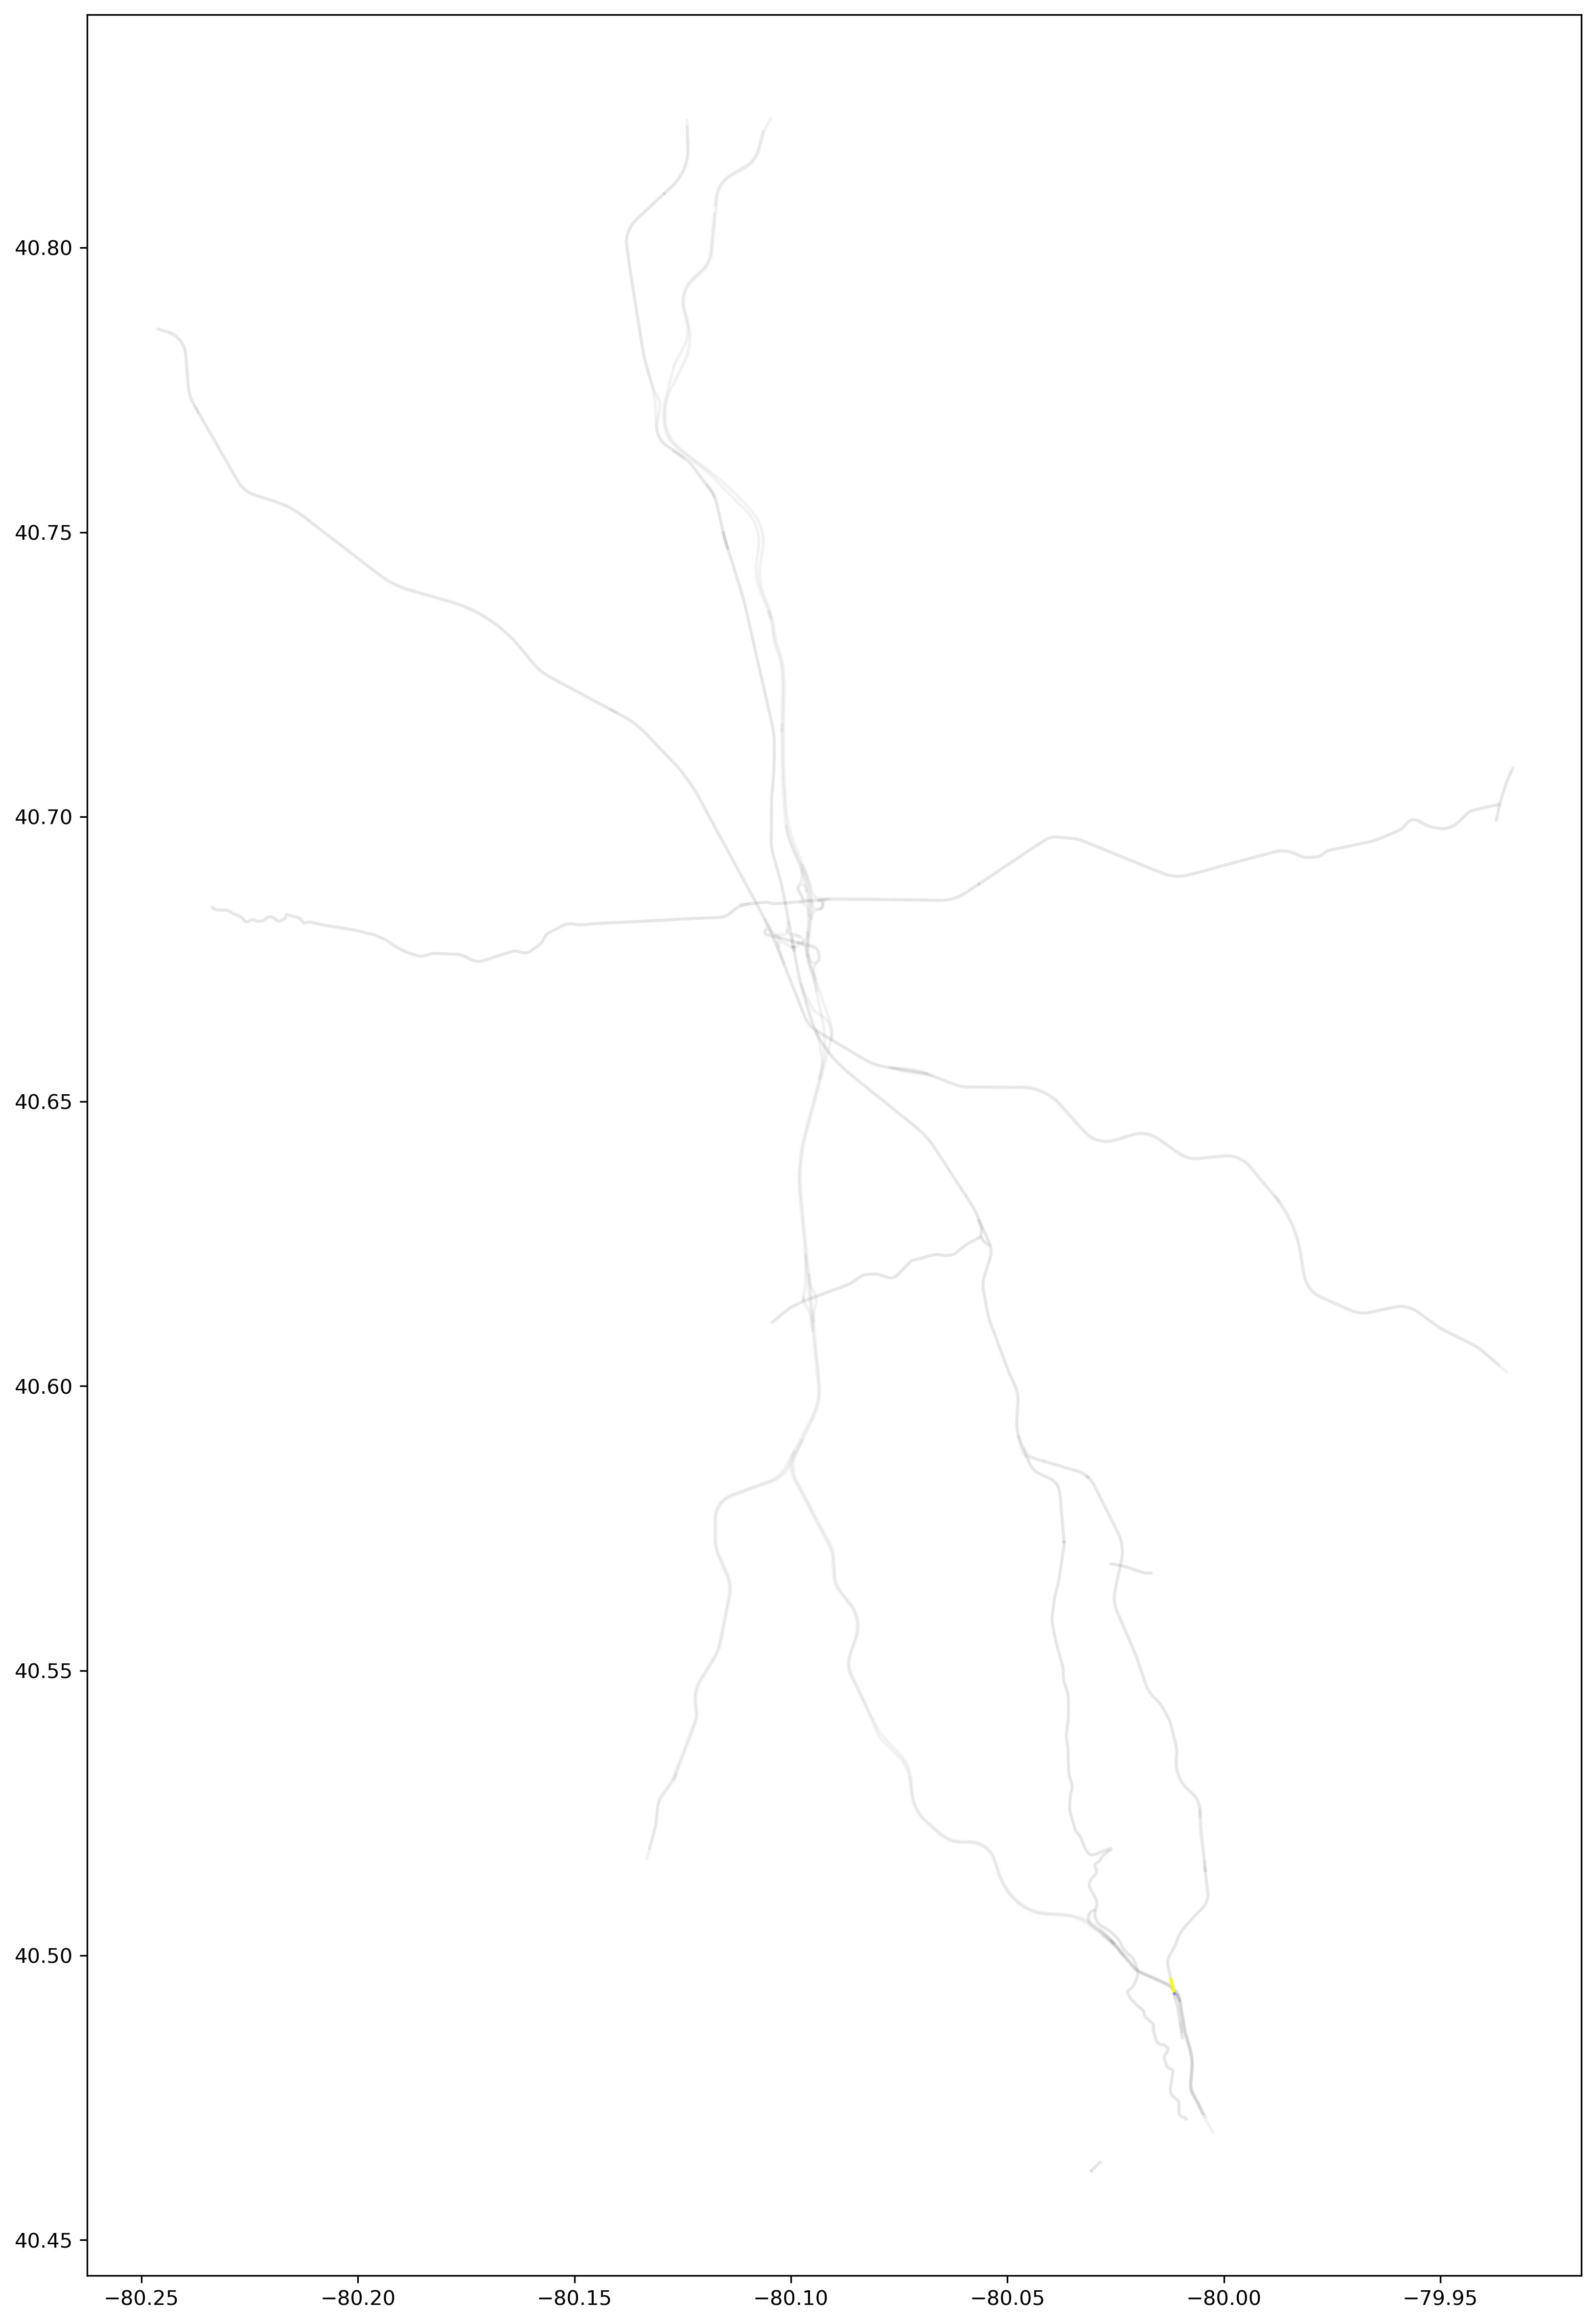

In [37]:
# Visualize and manually check initial calculation of previous neighbors

check_list = list(df_raw_prev_xd[df_raw_prev_xd.angle > 0.1].sort_values(by="angle", ascending=False).index) # 63
c = 62
i = check_list[c]
check_curr_xd = df_raw_prev_xd.iloc[i].id_xd_str_x
check_prev_xd = df_raw_prev_xd.iloc[i].id_xd_prev_str
print(check_curr_xd, df_raw_prev_xd.iloc[i].Bearing_x, check_prev_xd, df_raw_prev_xd.iloc[i].Bearing_y, df_raw_prev_xd.iloc[i].angle)
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
gdf_shp_xd.plot(ax=ax, color="grey", alpha=0.1)
gdf_shp_xd[gdf_shp_xd.id_xd_str == check_curr_xd].plot(ax=ax, color="yellow", alpha=0.9)
gdf_shp_xd[gdf_shp_xd.id_xd_str == check_prev_xd].plot(ax=ax, color="blue", alpha=0.3)

In [38]:
df_prev_xd = df_raw_prev_xd[["id_xd_str_x", "id_xd_prev_str"]].groupby("id_xd_str_x").agg(tuple).applymap(list).reset_index()
df_prev_xd.columns = ["id_xd_str", "prev_xd_str"] # shape (422, 2)

In [39]:
df_prev_xd

id_xd_str                                   prev_xd_str
0    1310221389  [429090969, 429090969, 429090964, 429090995]
1    1310221502                                   [134655106]
2    1310224523                        [429088784, 429088802]
3    1310224922                                  [1310442570]
4    1310224934                                  [1310224922]
..          ...                                           ...
417   429114491                                  [1310576547]
418   429114510                                  [1310576534]
419   429115759                                  [1310495697]
420   429115760                                   [429115759]
421   429115761                                  [1310495780]

[422 rows x 2 columns]

current xd:
429091258 61    N
Name: Bearing, dtype: object
previous xd:
1310261283 103    N
Name: Bearing, dtype: object 80   NaN
Name: angle, dtype: float64


<AxesSubplot: >

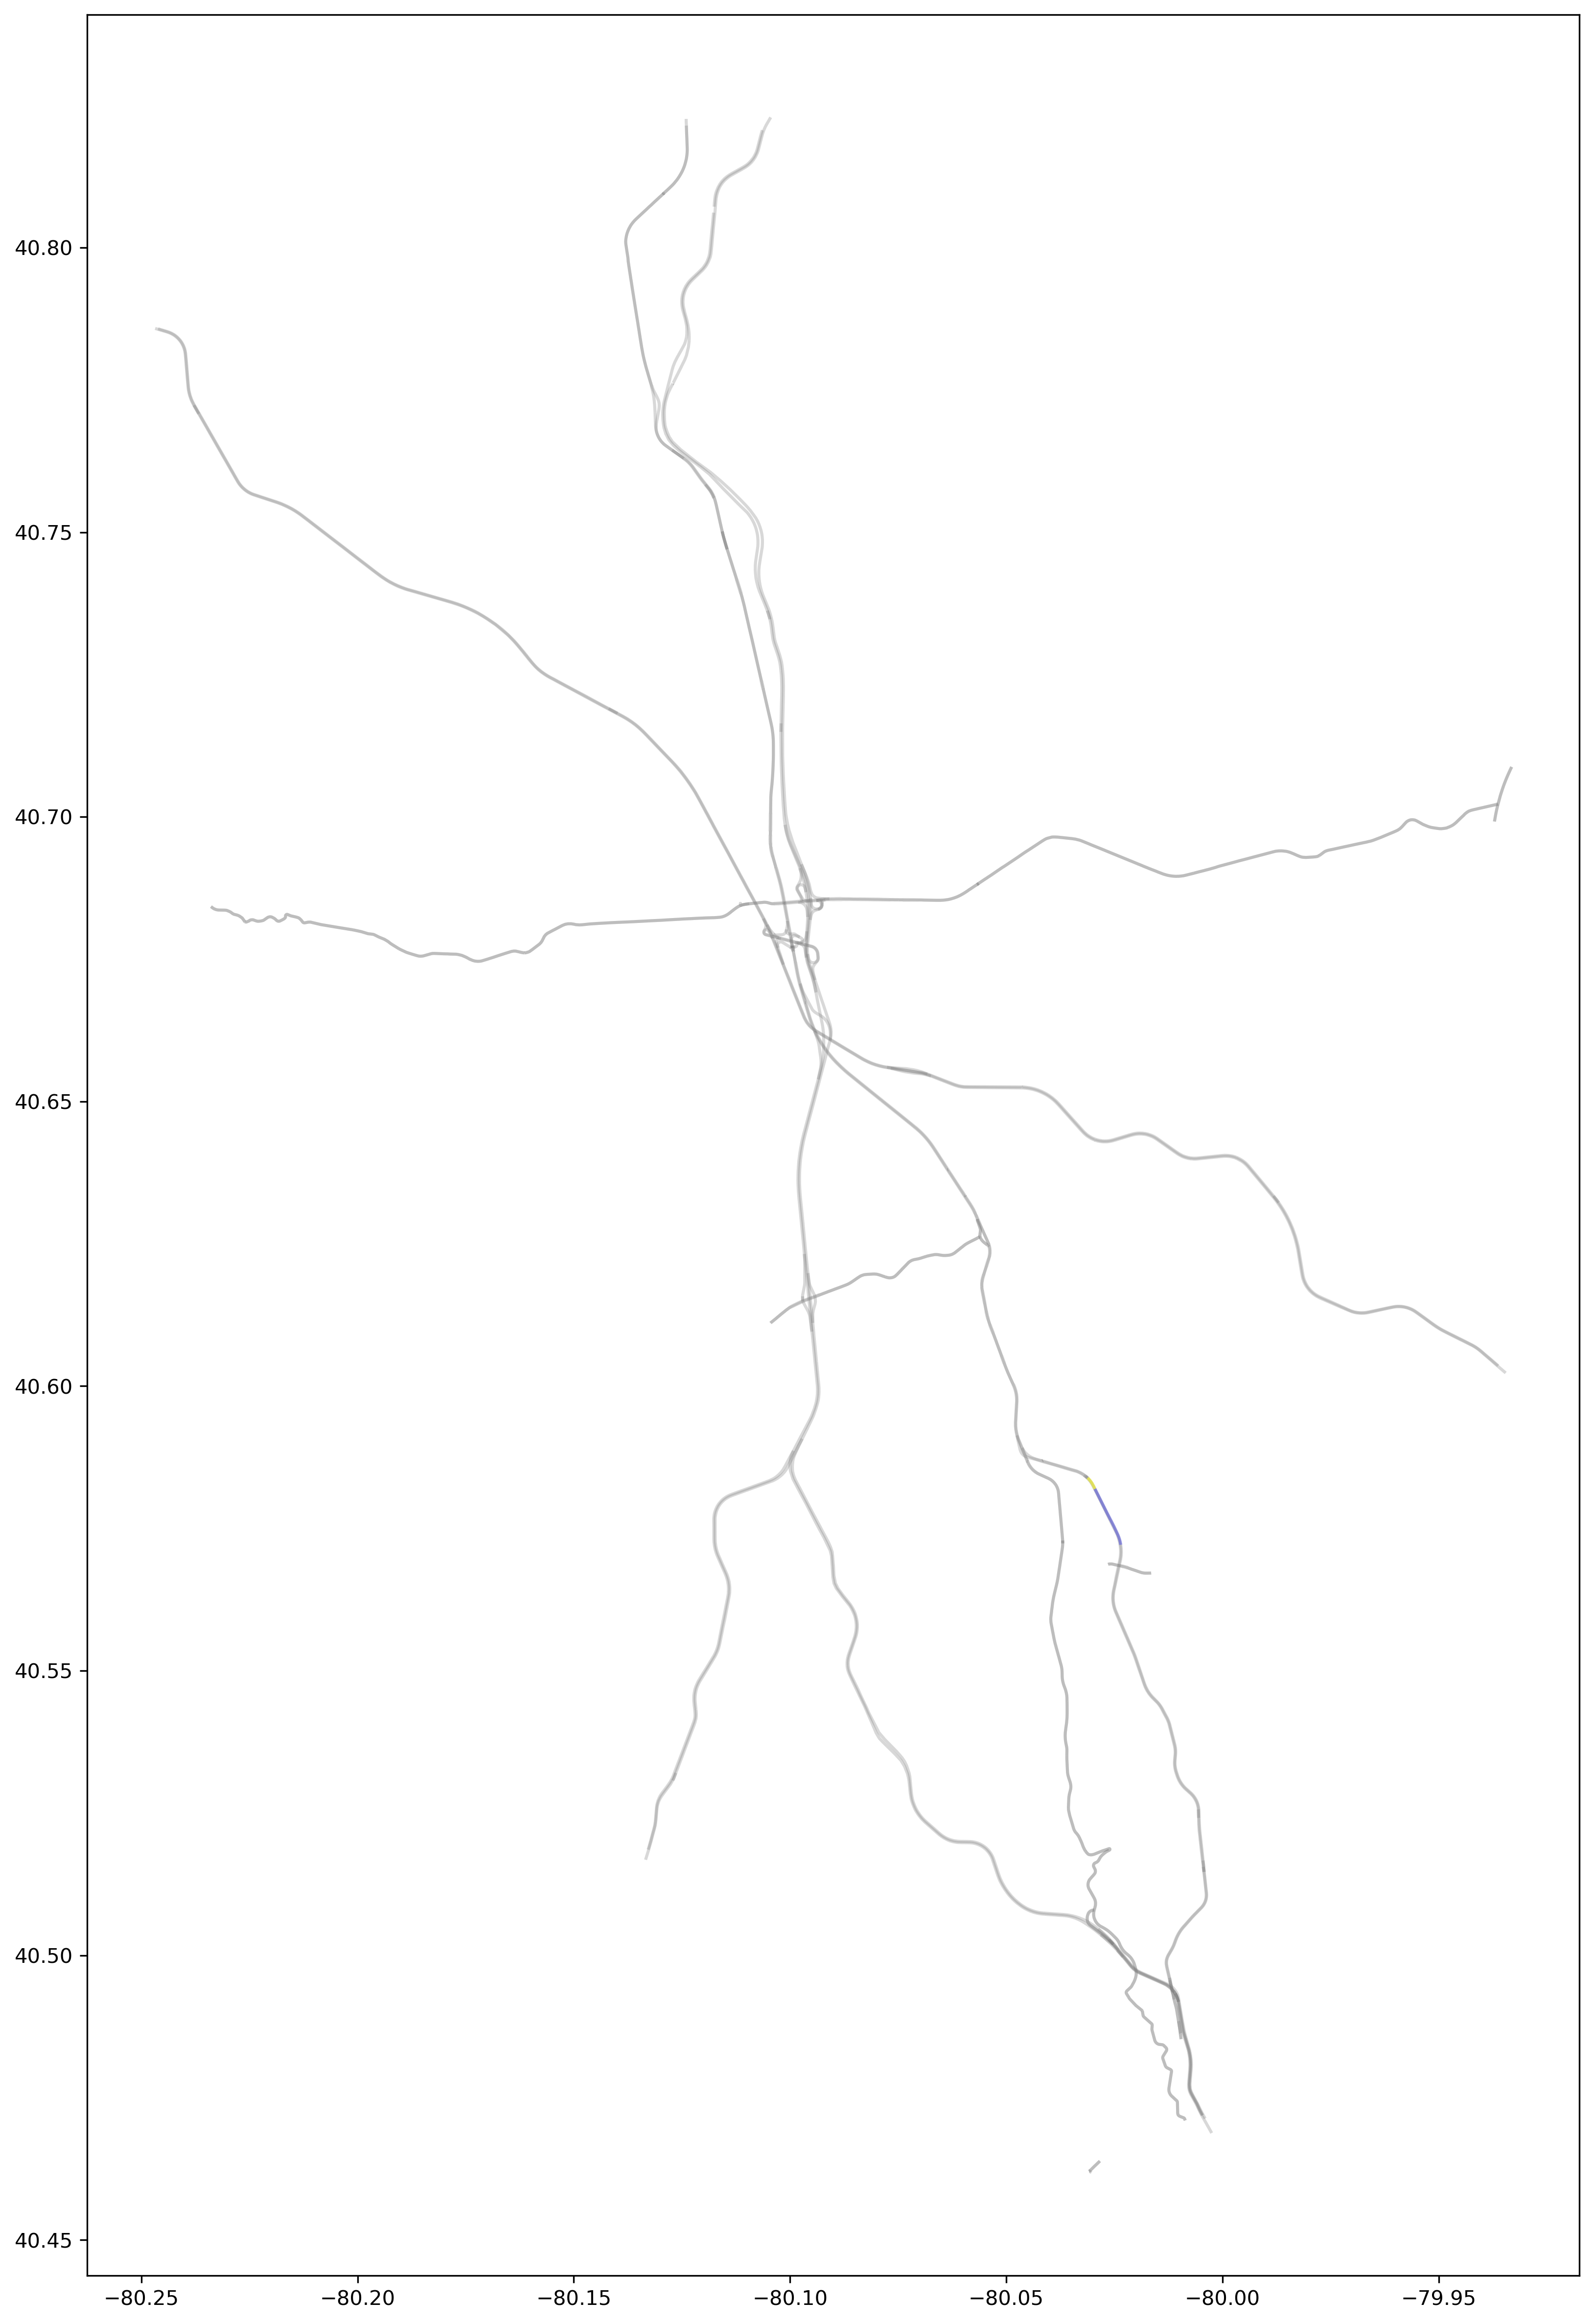

In [40]:
# Visualize and manually check intermediate calculation of previous neighbors

# there are 95 XD segments which have more than 1 previous neighbors
# [  0,   2,   9,  14,  16,  20,  21,  28,  40,  68,  70,  71,  82,
#              89,  95,  96,  97,  98, 100, 102, 104, 108, 110, 111, 112, 114,
#             115, 116, 117, 142, 157, 161, 180, 185, 187, 195, 208, 211, 213,
#             216, 249, 257, 259, 260, 275, 276, 278, 279, 287, 288, 292, 295,
#             296, 297, 298, 299, 301, 305, 308, 324, 325, 328, 329, 331, 332,
#             333, 334, 336, 342, 346, 351, 359, 360, 361, 365, 373, 374, 375,
#             377, 379, 380, 382, 384, 388, 391, 394, 395, 397, 398, 401, 402,
#             406, 408, 409, 412]
check_list = list(df_prev_xd[df_prev_xd.prev_xd_str.map(len) > 1].index)  
i = 407
check_curr_xd = df_prev_xd.iloc[i].id_xd_str
check_prev_xd = df_prev_xd.iloc[i].prev_xd_str
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
print("current xd:")
print(check_curr_xd, df_xd_attr[df_xd_attr.id_xd_str==check_curr_xd].Bearing)
print("previous xd:")
for c in check_prev_xd: 
    print(c, df_xd_attr[df_xd_attr.id_xd_str==c].Bearing, df_raw_prev_xd[(df_raw_prev_xd.id_xd_str_x==check_curr_xd) & (df_raw_prev_xd.id_xd_prev_str==c)].angle)
gdf_shp_xd.plot(ax=ax, color="grey", alpha=0.3)
gdf_shp_xd[gdf_shp_xd.id_xd_str == check_curr_xd].plot(ax=ax, color="yellow", alpha=0.5)
gdf_shp_xd[gdf_shp_xd.id_xd_str.isin(check_prev_xd)].plot(ax=ax, color="blue", alpha=0.3)

In [41]:
dict_prev_xd = dict(df_prev_xd.values) # contains 422 XD segments, 95 of which have more than one previous neighbors

{'1310445207', '134625815', '1310262275', '429088760', '429088785', '1310499840', '1310352790', '1310609751', '1310318737', '1310427861', '1310275424', '1310594249', '1310505317', '1310331653', '389156136', '1310576350', '1310319396', '389134964', '1310597390', '134198813', '1310563997', '1310252437', '1310574747', '1310376229', '389109598', '1310427874'}
     OID  id_xd_str  id_xd_prev  id_xd_next FRC RoadNumber  \
21  None  389156136  1310456047  1310456094   1       None   

               RoadName LinearID        Country         State  ... SpecialRoa  \
21  Freedom Crider Road     None  United States  Pennsylvania  ...       None   

               RoadList  StartLat  StartLong    EndLat    EndLong Bearing  \
21  Freedom Crider Road  40.67517  -80.17448  40.67595  -80.18299       W   

    XDGroup ShapeSRID                                           geometry  
21  2007597      4326  MULTILINESTRING ((-80.17448 40.67517, -80.1747...  

[1 rows x 25 columns]


<AxesSubplot: title={'center': 'XD Segments with (422, yellow) & without (26, blue) prev neighbors'}>

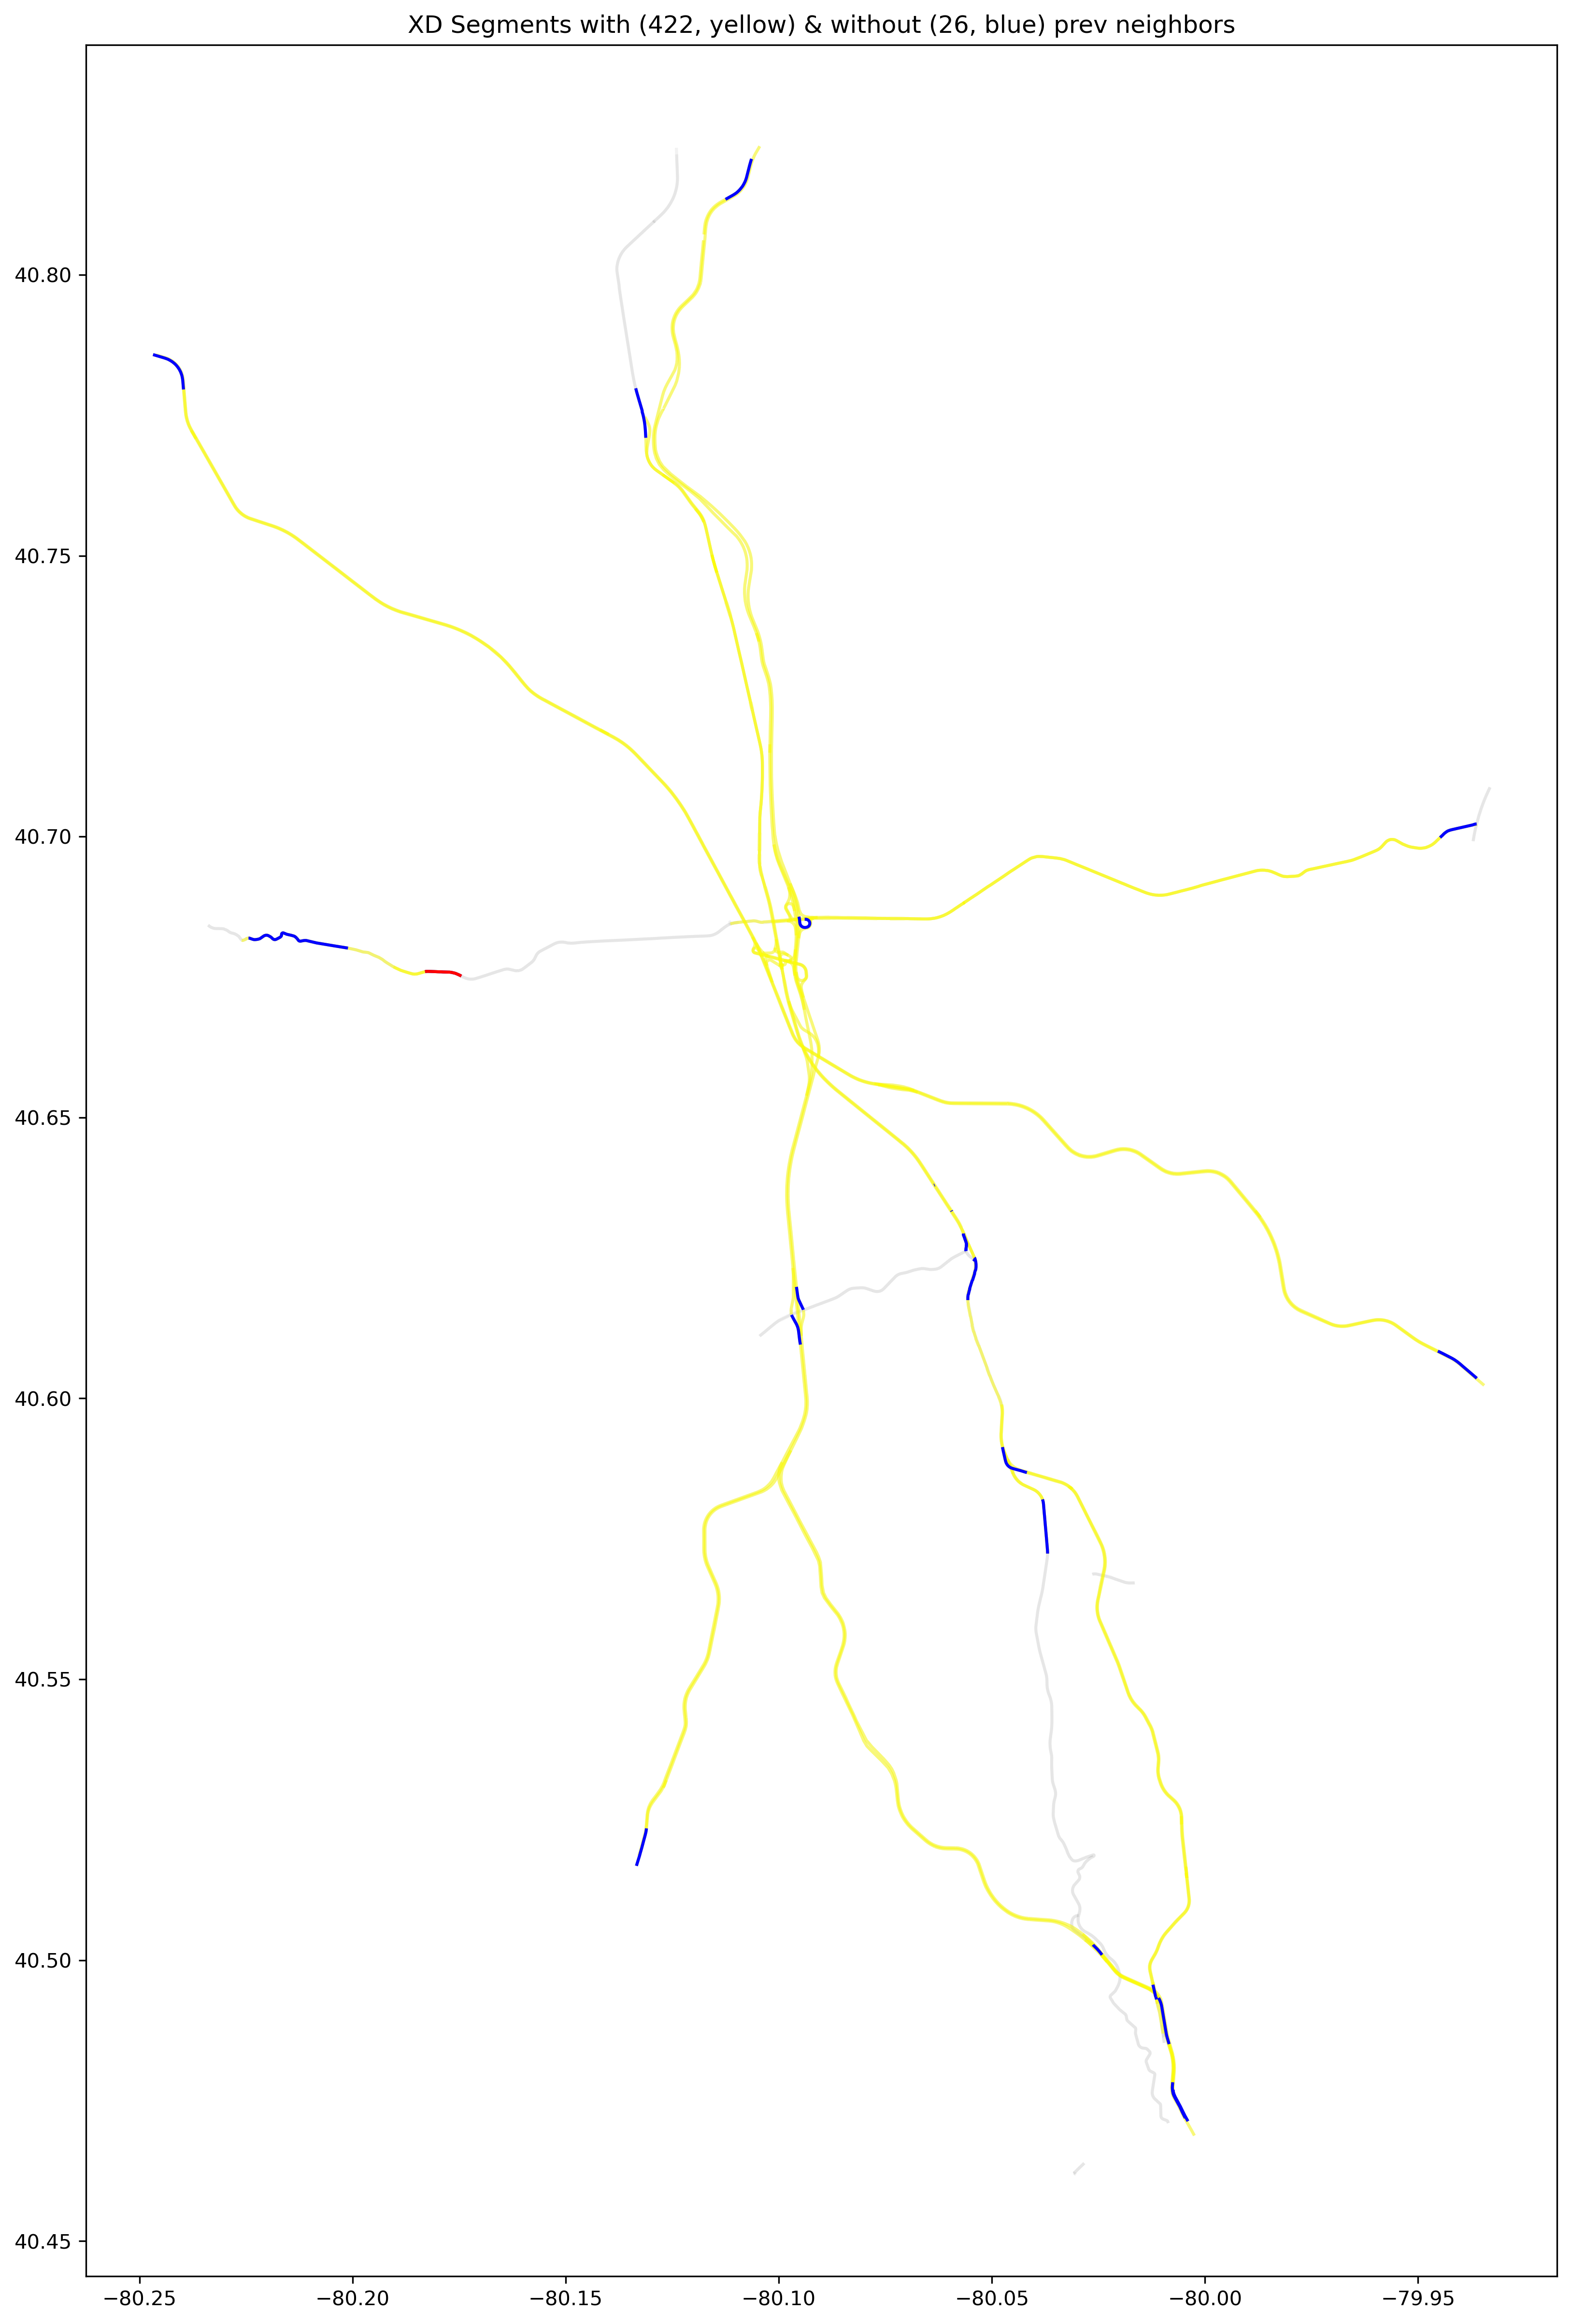

In [42]:
# Visualize and manually check segments without previous neighbors

# There are 26 segments initially found without any immediate prev neighbor
# I have manually checked their neighbors on QGIS (with cranberry_tmc and PA_tmc), they either go missing in cranberry_tmc shapefile or lack speed data

# 应该有prev neighbor的
    # "1310597390": "1310597509". 方向相反是因为转弯过大
    # "1310609751": "388033389" （待定，"388033389"跟 "1310609751"没有首尾相接，而是分岔开来）
    # "429088760": "387963279" (待定，没有完全分开，部分重叠)

print(set_xd_segments.difference(dict_prev_xd)) 
check_curr_xd = "389156136"
print(df_xd_attr[df_xd_attr.id_xd_str==check_curr_xd])
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("XD Segments with (422, yellow) & without (26, blue) prev neighbors")
gdf_shp_xd.plot(ax=ax, color="grey", alpha=0.1)
gdf_shp_xd[gdf_shp_xd.id_xd_str.isin(set_xd_segments)].plot(ax=ax, color="yellow", alpha=0.5)
gdf_shp_xd[(gdf_shp_xd.id_xd_str.isin(set_xd_segments)) & (~gdf_shp_xd.id_xd_str.isin(dict_prev_xd))].plot(ax=ax, color="blue", alpha=1)
gdf_shp_xd[gdf_shp_xd.id_xd_str==check_curr_xd].plot(ax=ax, color="red")

In [43]:
dict_prev_xd["1310597390"] = ["1310597509"]
dict_prev_xd["1310609751"] = ["388033389"]
dict_prev_xd["429088760"] = ["387963279"]

# dict_prev_xd covers 425 xd segments

In [67]:
with open("../../data/dict_prev_xd.pkl", "wb") as f:
    pickle.dump(dict_prev_xd, f)

<AxesSubplot: >

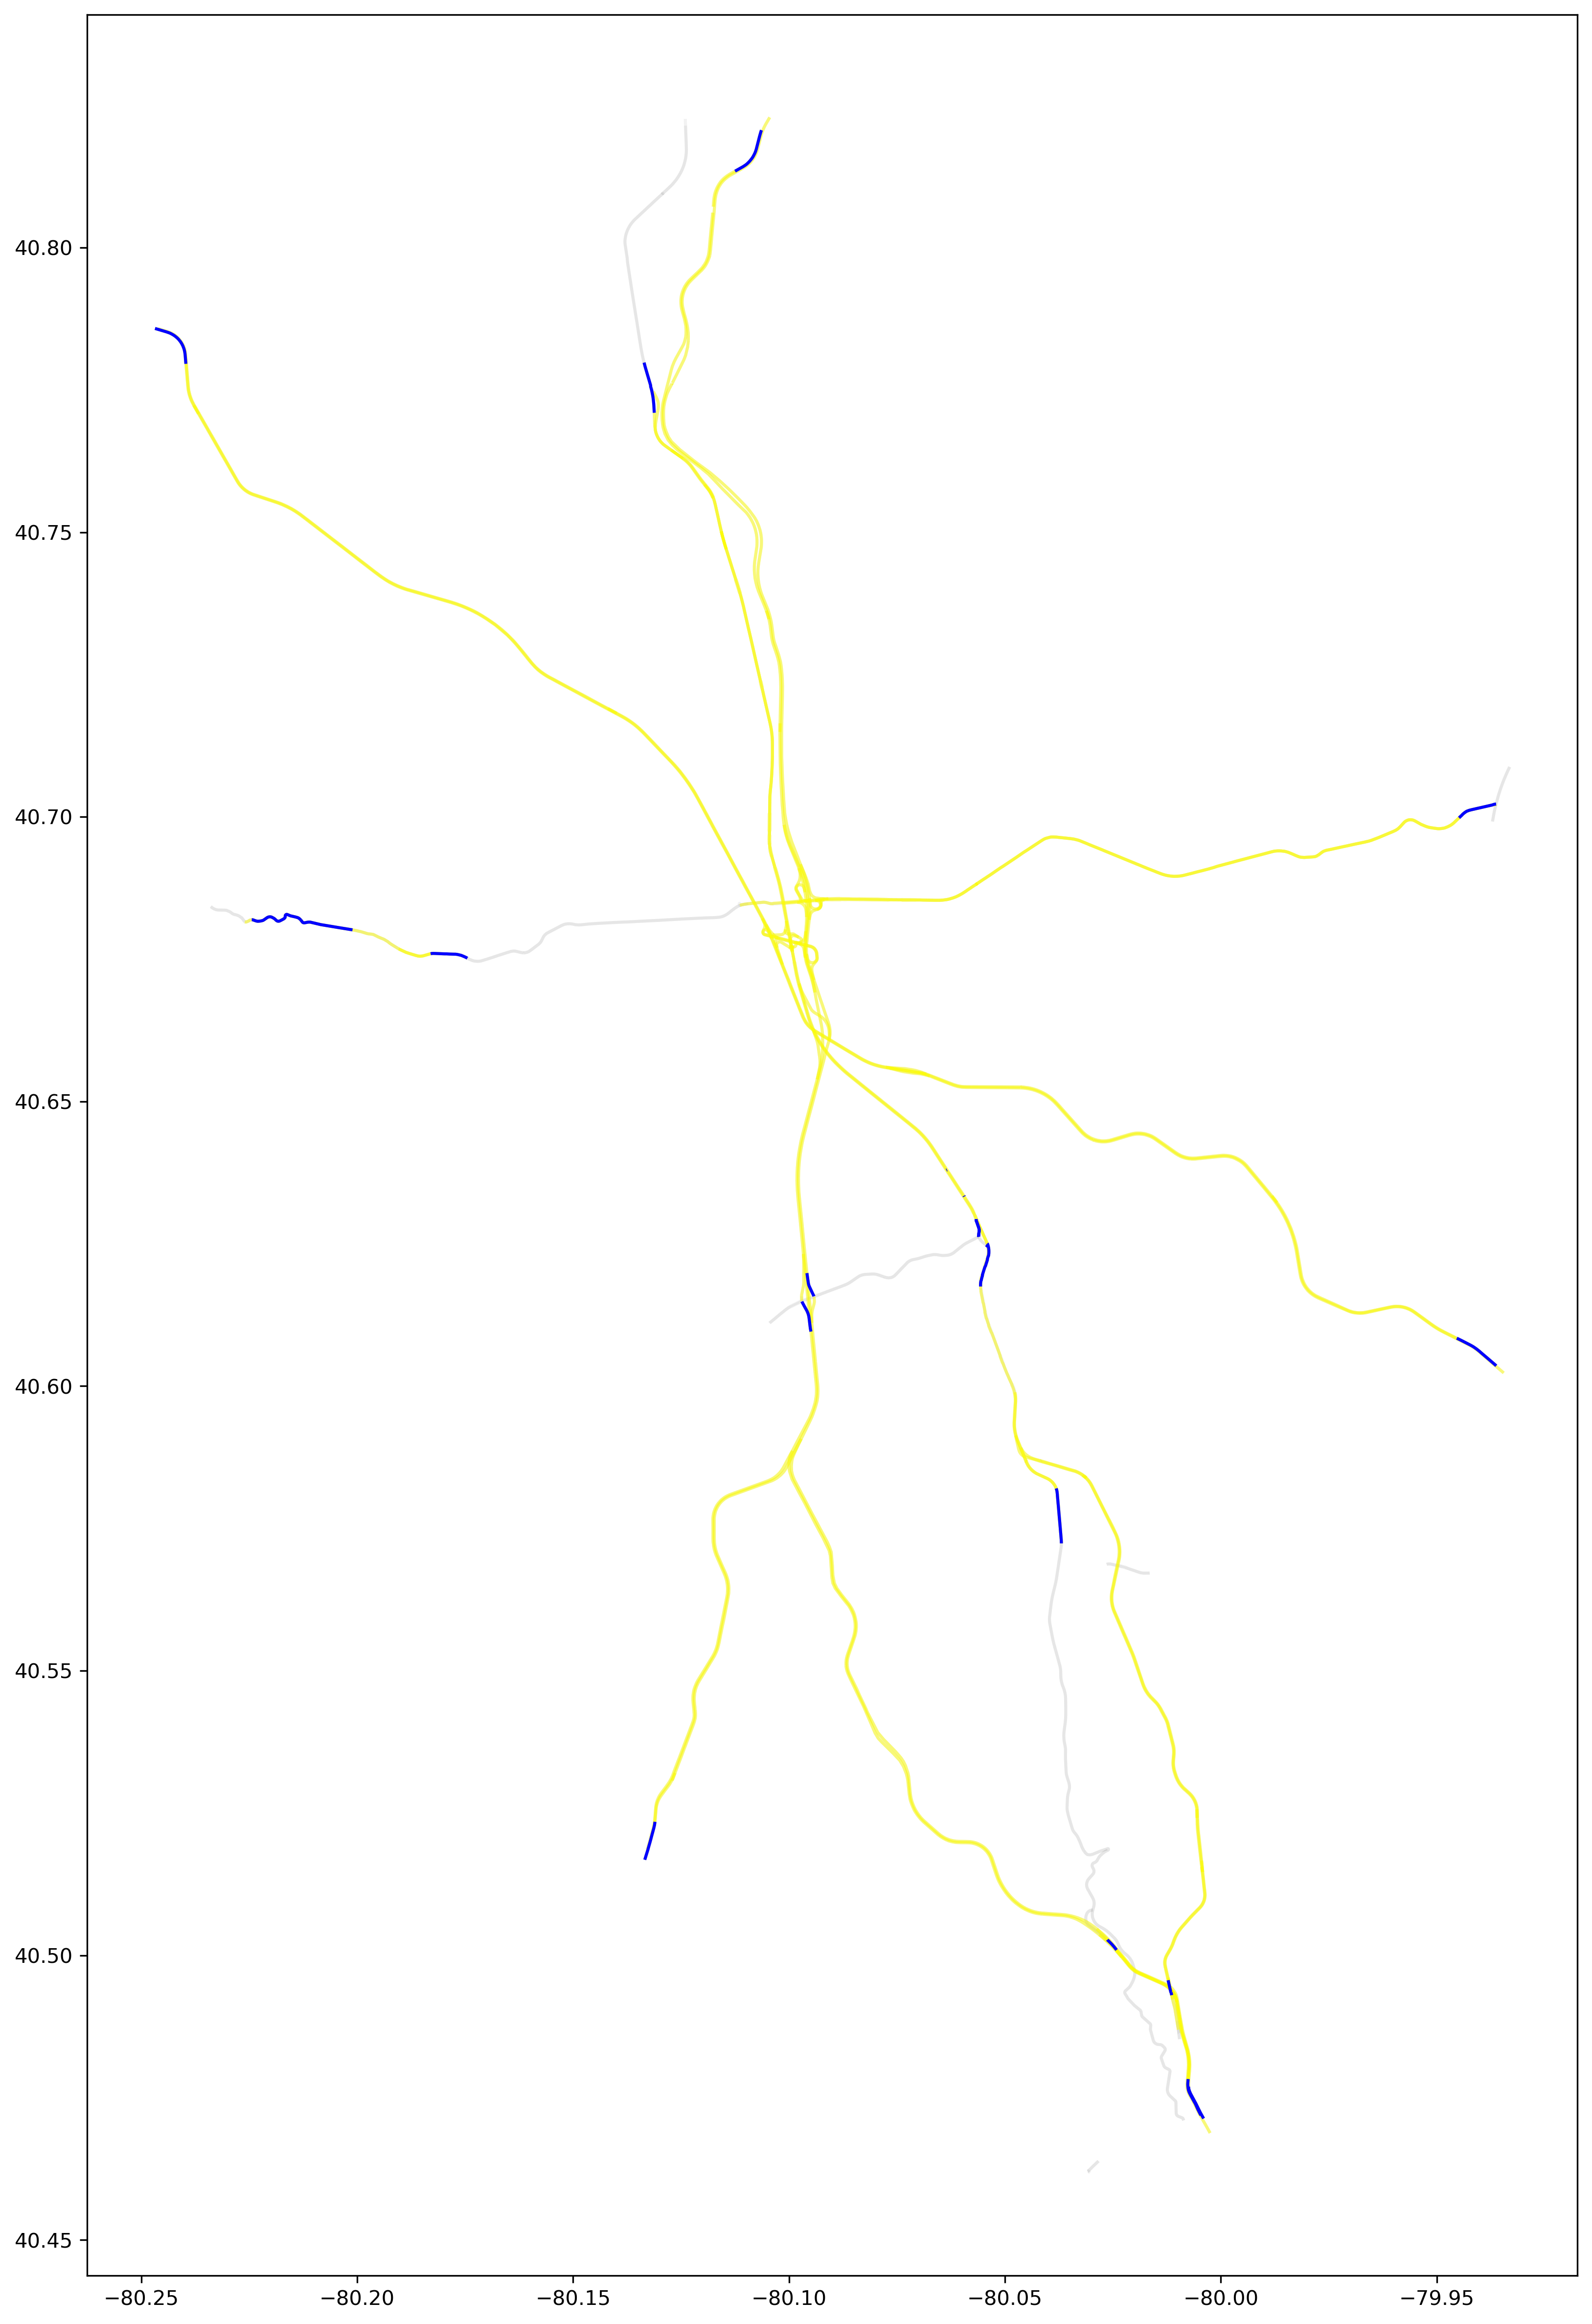

In [44]:
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
gdf_shp_xd.plot(ax=ax, color="grey", alpha=0.1)
gdf_shp_xd[gdf_shp_xd.id_xd_str.isin(set_xd_segments)].plot(ax=ax, color="yellow", alpha=0.5)
gdf_shp_xd[(gdf_shp_xd.id_xd_str.isin(set_xd_segments)) & (~gdf_shp_xd.id_xd_str.isin(dict_prev_xd))].plot(ax=ax, color="blue", alpha=1)

### 2.3 Calculate upstream and downstream neighbors for each XD segment using their immediate prev and next

In [45]:
dict_upstream_xd = {}
for source in tqdm(list(set_xd_segments)):
    dict_upstream_xd[source] = compute_upstream(source, dict_prev_xd, dict_upstream_xd)

100%|██████████| 448/448 [13:42<00:00,  1.84s/it]


In [70]:
with open("../../data/dict_upstream_xd_str.pkl", "wb") as f:
    pickle.dump(dict_upstream_xd, f)

current xd:  1310593179 403    N
Name: Bearing, dtype: object
MORE THAN ONE UPSTREAM PATH!!! There are 5466 upstream paths


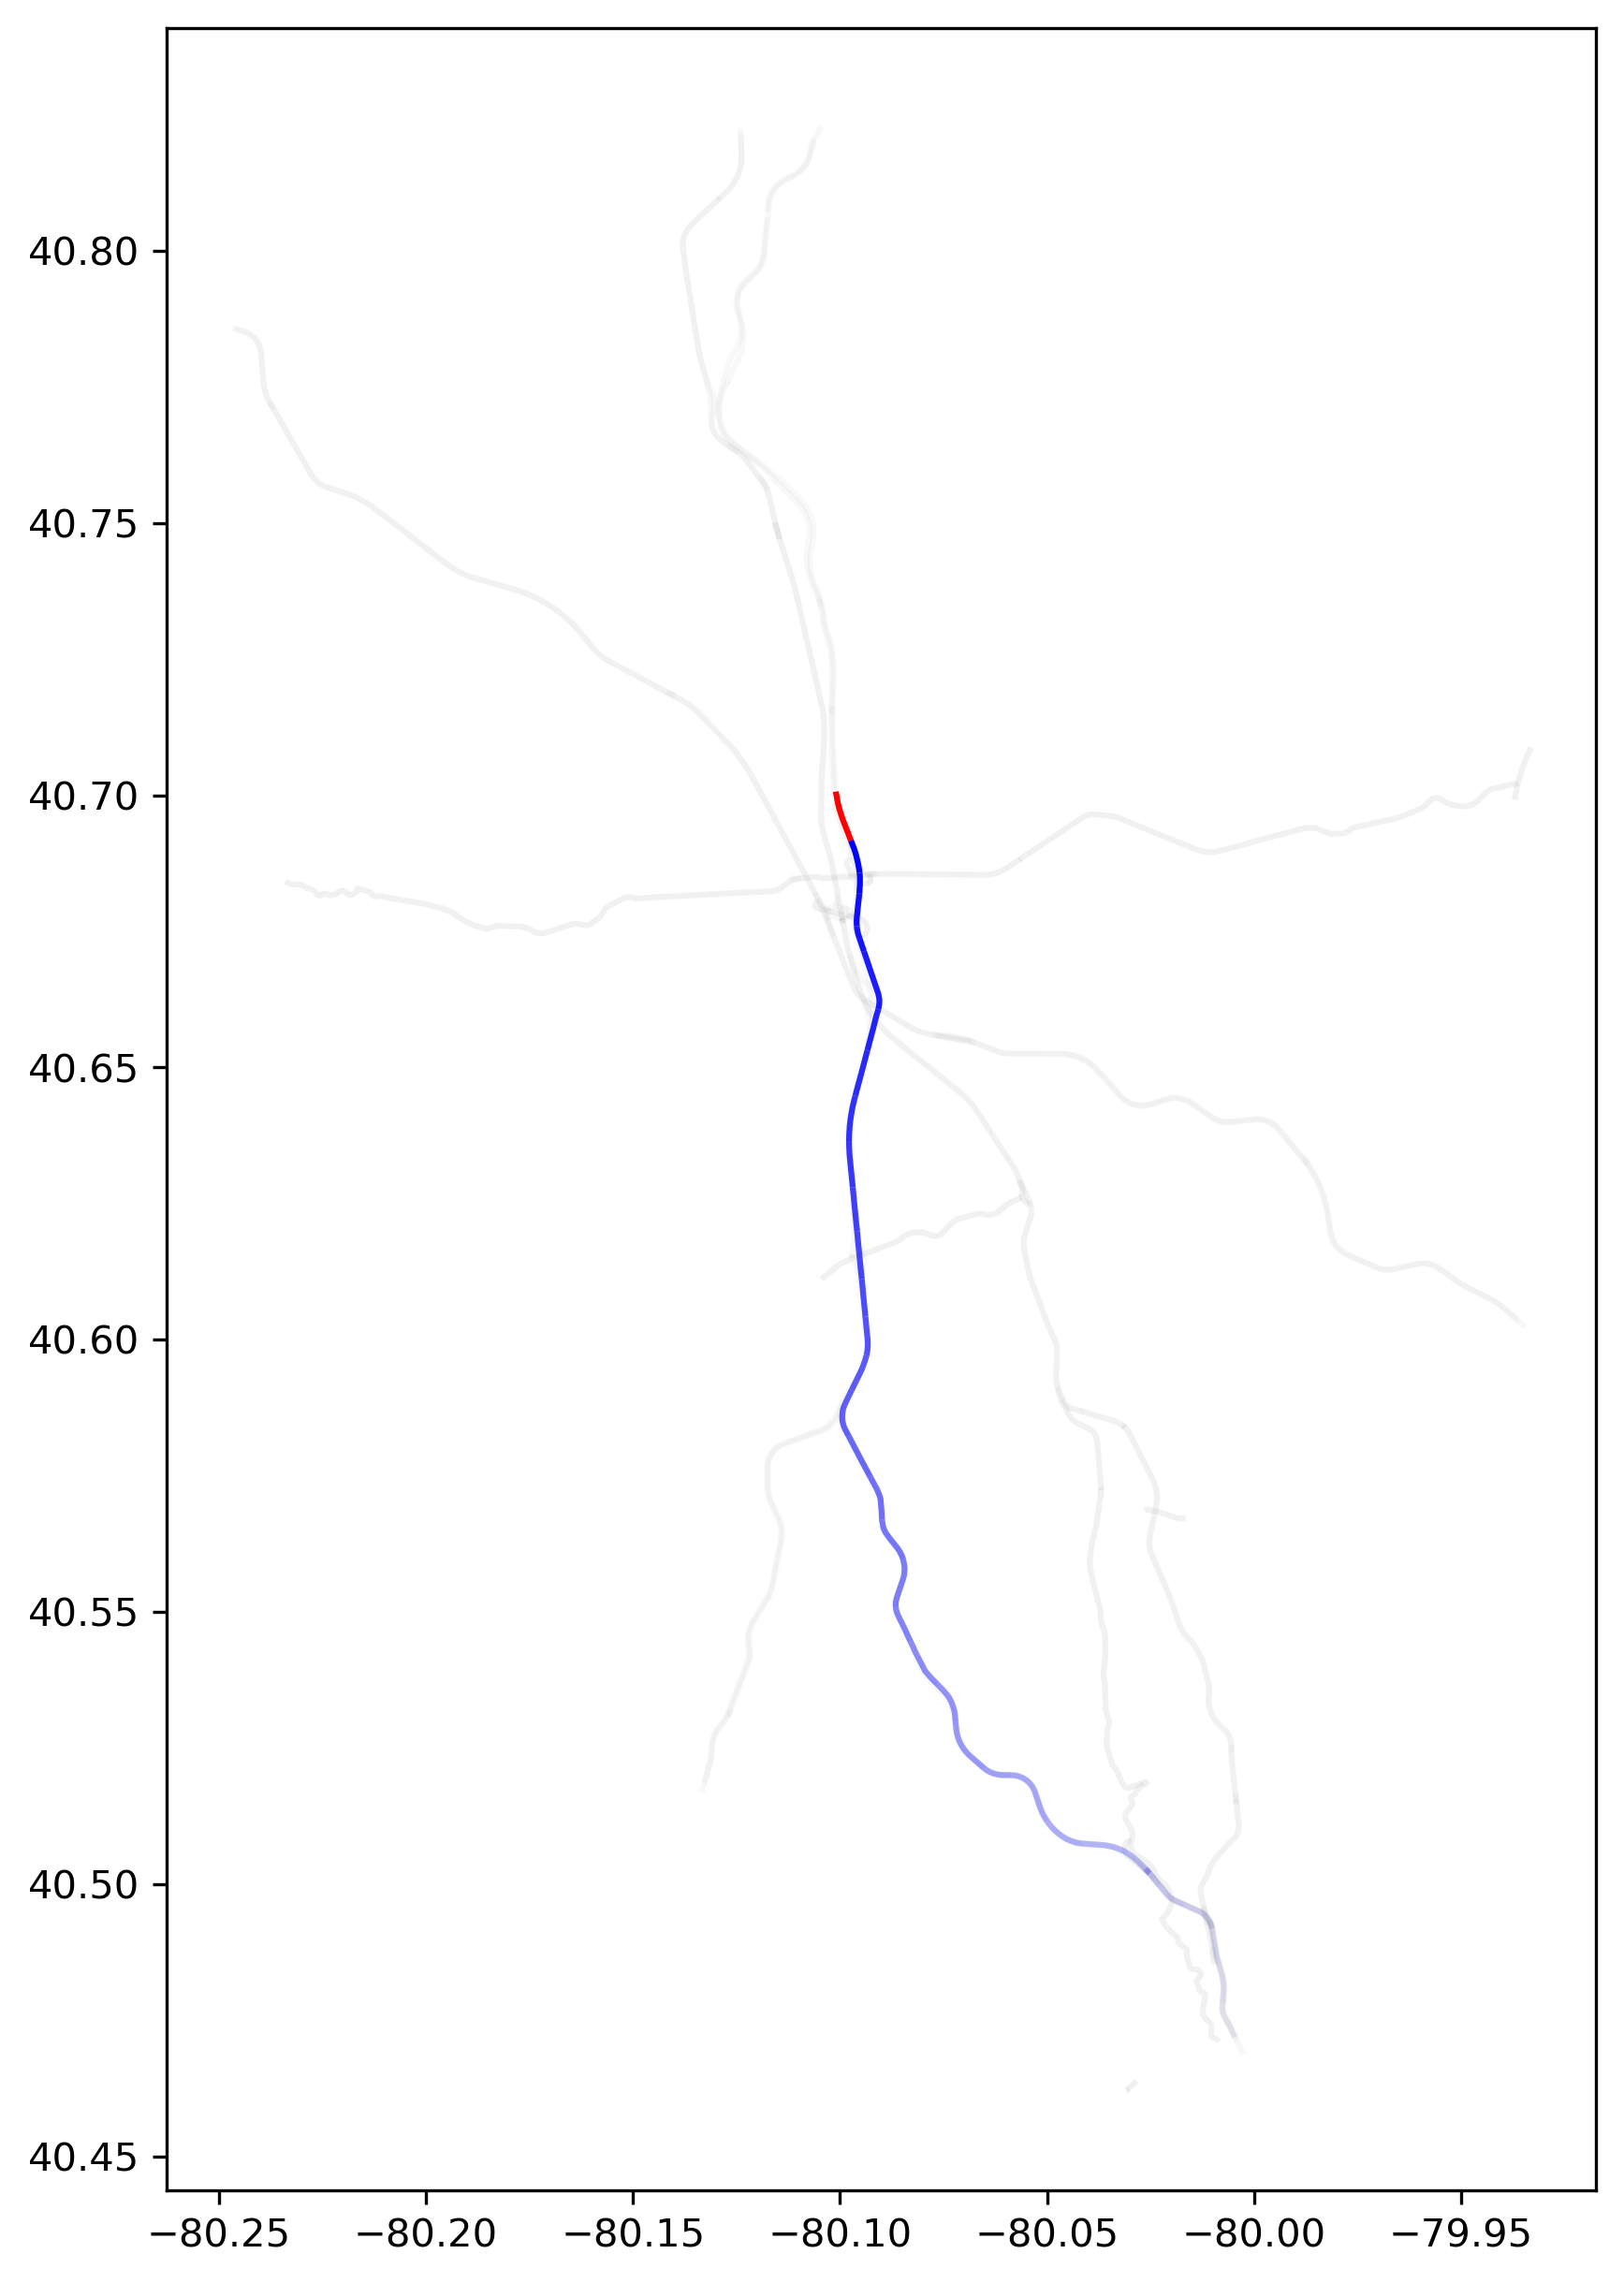

In [49]:
# Visualize and manually check upstream segments starting from each of 4 segments
i = 7
check_curr_xd = list(set_xd_segments)[i]
print("current xd: ", check_curr_xd, df_xd_attr[df_xd_attr.id_xd_str == check_curr_xd].Bearing)
check_upstream = dict_upstream_xd[check_curr_xd]
# print("upstream: ", check_upstream)
# fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
fig, ax = plt.subplots(1,figsize=(15,10), dpi=300)
gdf_shp_xd.plot(ax=ax, color="grey", alpha=0.05) # entire XD segments in cranberry 
# gdf_shp_xd[(gdf_shp_xd.id_xd_str.isin(set_xd_segments)) & (~gdf_shp_xd.id_xd_str.isin(dict_prev_xd))].plot(ax=ax, color="yellow") # TMC segments without prev neighbors
gdf_shp_xd[gdf_shp_xd.id_xd_str == check_curr_xd].plot(ax=ax, color="red") # source
if len(check_upstream) > 1:
    print(f"MORE THAN ONE UPSTREAM PATH!!! There are {len(check_upstream)} upstream paths")
j = 6
for k, u in enumerate(check_upstream[j]):
    gdf_shp_xd[gdf_shp_xd.id_xd_str == u].plot(ax=ax, color="blue", alpha= (len(check_upstream[j])-k)/len(check_upstream[j]))  # upstream segments

# 3. Limit Upstream within Range

In [ ]:
range = 5

In [ ]:
# Generate upstream (within range) for each TMC segment
# Execution Time: instant
dict_upstream_tmc_within_range = {}
for tmc in tqdm(list(set_tmc_segments)):
    if not dict_upstream_tmc[tmc][0]:
        dict_upstream_tmc_within_range[tmc] = [[]]
        continue
    else:
        dict_upstream_tmc_within_range[tmc] = []
        for upstream in dict_upstream_tmc[tmc]:
            dist = range
            i = 0
            while i < len(upstream) and dist >= 0:
                dist -= dict_miles_tmc[upstream[i]]
                i += 1
            dict_upstream_tmc_within_range[tmc] += [upstream[:i]]

In [ ]:
# Generate upstream (within range) for each XD segment
# Execution Time: ~10 min (for range=5)
dict_upstream_xd_within_range = {}
for xd in tqdm(list(set_xd_segments)):
    if not dict_upstream_xd[xd][0]:
        dict_upstream_xd_within_range[xd] = [[]]
        continue
    else:
        dict_upstream_xd_within_range[xd] = []
        for upstream in dict_upstream_xd[xd]:
            dist = range
            i = 0
            while i < len(upstream) and dist >= 0:
                dist -= dict_miles_xd[upstream[i]]
                i += 1
            dict_upstream_xd_within_range[xd] += [upstream[:i]]

# 4. Convert Dict of All Upstream List to Dict of Unique Upstream Segments

In [1]:
def convert_dict_upstream_to_dict_upstream_set(dict_upstream, set_segments):
    dict_upstream_set = {}
    for seg in tqdm(list(set_segments)):
        seg_upstream_list = []
        for upstream in dict_upstream[seg]:
            seg_upstream_list += upstream
        dict_upstream_set[seg] = set(seg_upstream_list)
    return dict_upstream_set

In [4]:
dict_upstream_xd_str = pickle.load(open("../../data/dict_upstream_xd_str.pkl", "rb"))
dict_upstream_tmc = pickle.load(open("../../data/dict_upstream_tmc.pkl", "rb"))
dict_upstream_xd_str_5_miles = pickle.load(open("../../data/dict_upstream_xd_str_5_miles.pkl", "rb"))
dict_upstream_tmc_5_miles = pickle.load(open("../../data/dict_upstream_tmc_5_miles.pkl", "rb"))

In [5]:
set_tmc_segments_for_upstream = pickle.load(open("./set_tmc_segments_for_upstream.pkl", "rb"))
set_xd_segments_str_for_upstream = pickle.load(open("./set_xd_segments_str_for_upstream.pkl", "rb"))

In [6]:
dict_upstream_unique_tmc = convert_dict_upstream_to_dict_upstream_set(dict_upstream_tmc, set_tmc_segments_for_upstream)
dict_upstream_unique_xd_str = convert_dict_upstream_to_dict_upstream_set(dict_upstream_xd_str, set_xd_segments_str_for_upstream)
dict_upstream_unique_tmc_5_miles = convert_dict_upstream_to_dict_upstream_set(dict_upstream_tmc_5_miles, set_tmc_segments_for_upstream)
dict_upstream_unique_xd_str_5_miles = convert_dict_upstream_to_dict_upstream_set(dict_upstream_xd_str_5_miles, set_xd_segments_str_for_upstream)

100%|██████████| 448/448 [00:10<00:00, 42.86it/s] 


In [7]:
pickle.dump(dict_upstream_unique_tmc, open("../../data/dict_upstream_unique_tmc.pkl", "wb"))
pickle.dump(dict_upstream_unique_xd_str, open("../../data/dict_upstream_unique_xd_str.pkl", "wb"))
pickle.dump(dict_upstream_unique_tmc_5_miles, open("../../data/dict_upstream_unique_tmc_5_miles.pkl", "wb"))
pickle.dump(dict_upstream_unique_xd_str_5_miles, open("../../data/dict_upstream_unique_xd_str_5_miles.pkl", "wb"))